## <span style="color:#db7d60">Setup</span>

In [2]:
%load_ext autoreload
%autoreload 2

import json
import math
import pickle
import numpy as np
import pandas as pd
import textwrap
import sys
from pathlib import Path
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

# pUtil needs to be loaded from the root directory
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))

import pUtil
from analysis_common import *
import data_manager
import analysis as anal
from analysis import plotting as aplt

import vector
from particle import Particle
from particle import PDGID

plt.rcParams['figure.figsize'] = (21, 6)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

/global/homes/e/eshy/.local/lib/python3.11/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


## <span style="color:#db7d60">Analysis</span>

In [3]:
model_name = 'model_5_9_1'
input_leading_path = pUtil.get_model_preparation_dir(model_name) / 'real_leading_test_particles.csv'

columns = ["num_particles", "pdgid", "e", "px", "py", "pz", "pt", "eta", "theta", "phi"]
real_df = pd.read_csv(input_leading_path, sep=" ", names=columns, engine="c", header=None)

### 1

Check what log transforming eta and phi will do to the distribution.

default eta dist


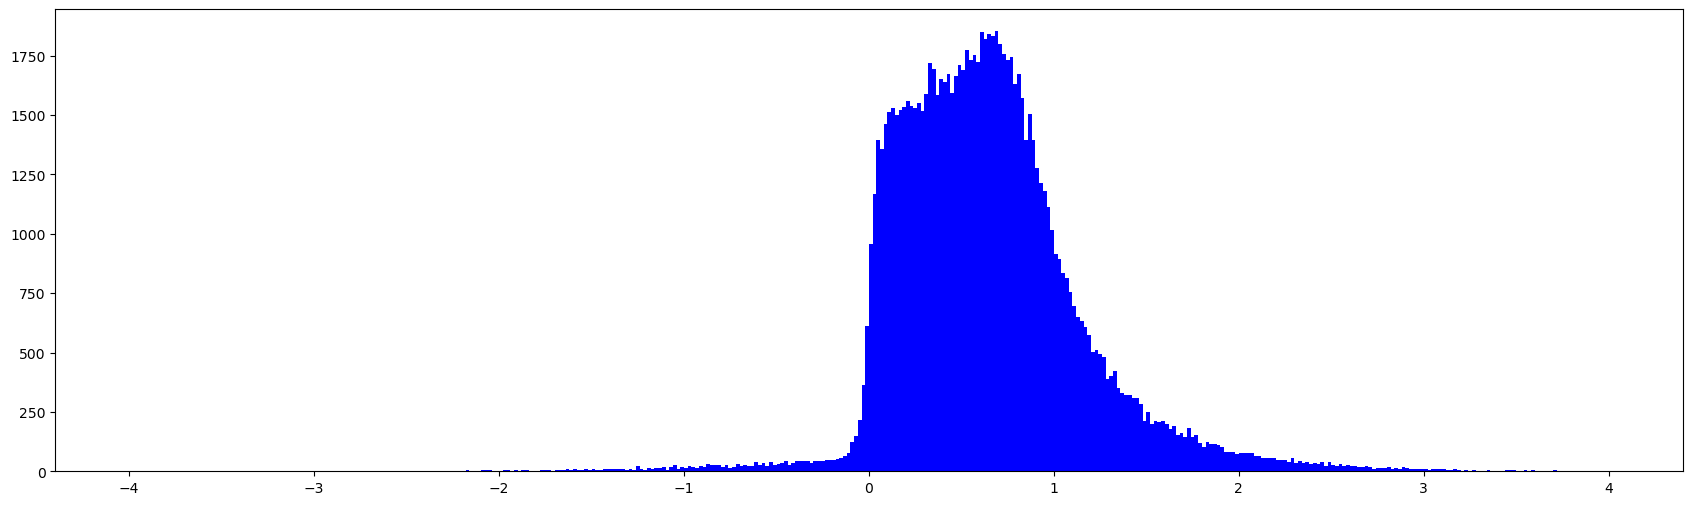

shifted eta dist (to avoid negative values)


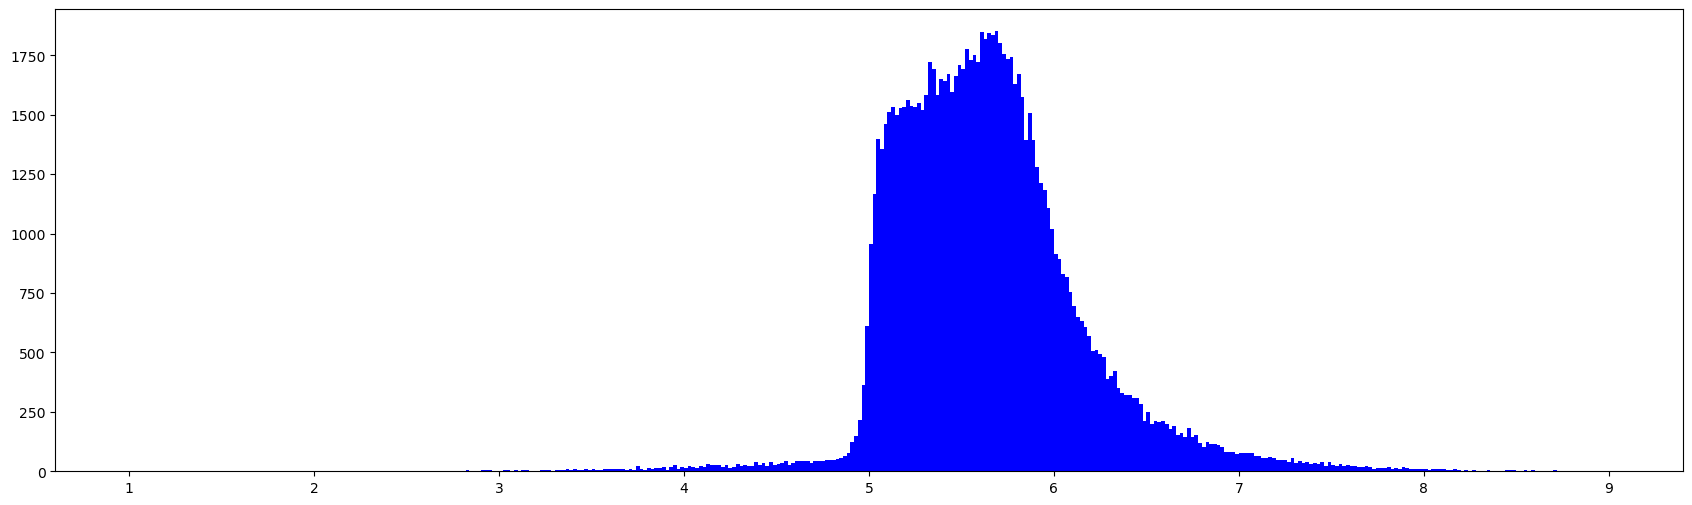

log transformed eta dist


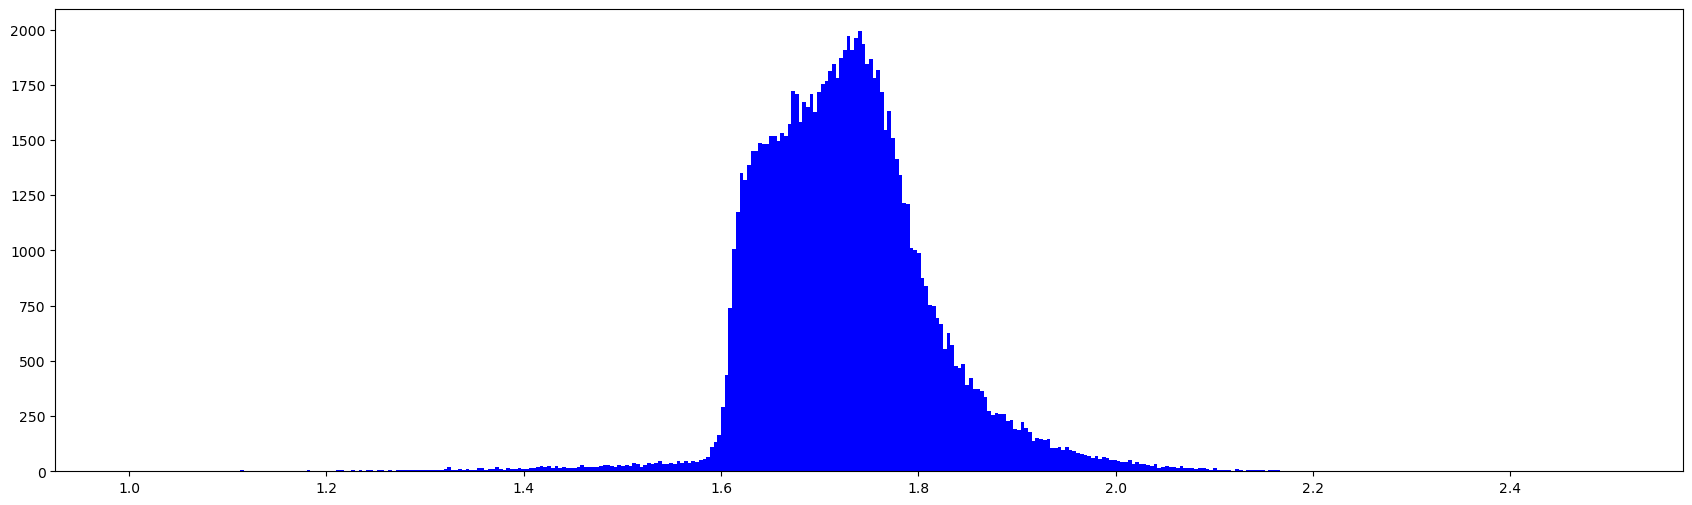

exponentiated log transformed eta dist


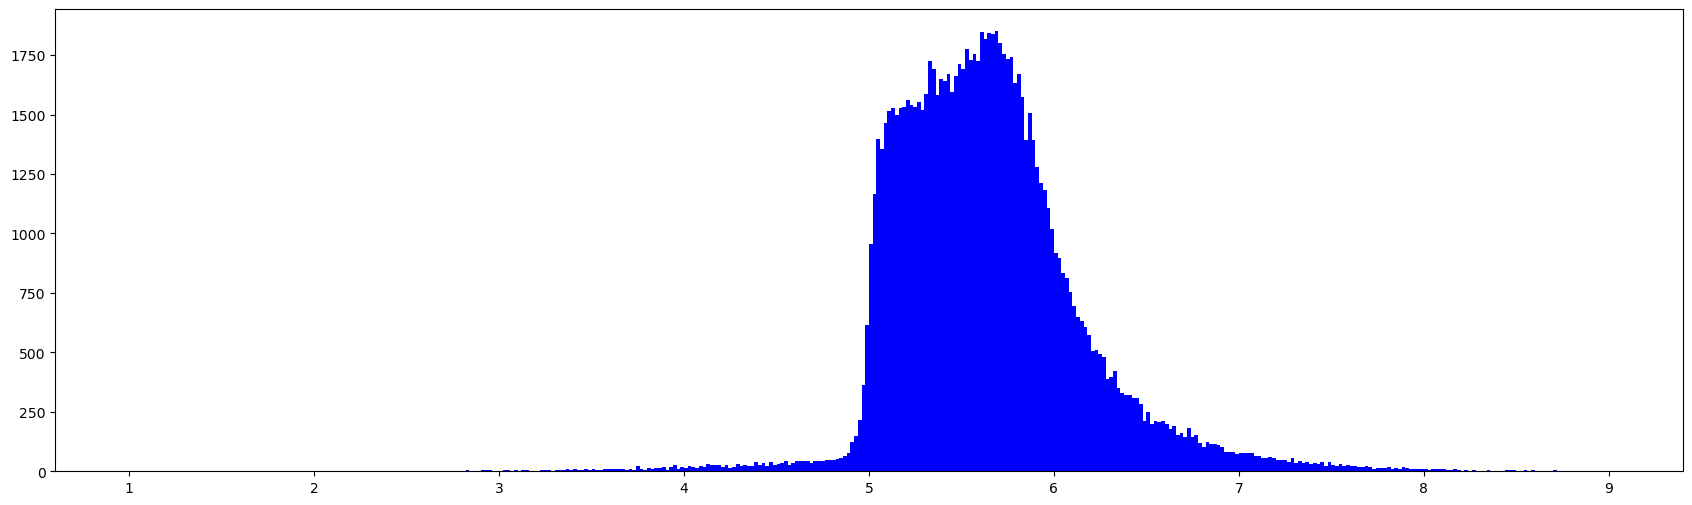

In [4]:
print('default eta dist')
plt.hist(real_df['eta'], range=(-4, 4), bins=400, label='eta', color=anal.plotting.colors[0])
plt.show()

print('shifted eta dist (to avoid negative values)')
shifted_eta = real_df['eta'].to_numpy() + 5
plt.hist(shifted_eta, range=(1, 9), bins=400, label='eta', color=anal.plotting.colors[0])
plt.show()

print('log transformed eta dist')
log_transformed_eta = np.log(shifted_eta)
plt.hist(log_transformed_eta, range=(1, 2.5), bins=400, label='eta', color=anal.plotting.colors[0])
plt.show()

print('exponentiated log transformed eta dist')
reverse_log_transformed_eta = np.exp(log_transformed_eta)
plt.hist(reverse_log_transformed_eta, range=(1, 9), bins=400, label='eta', color=anal.plotting.colors[0])
plt.show()

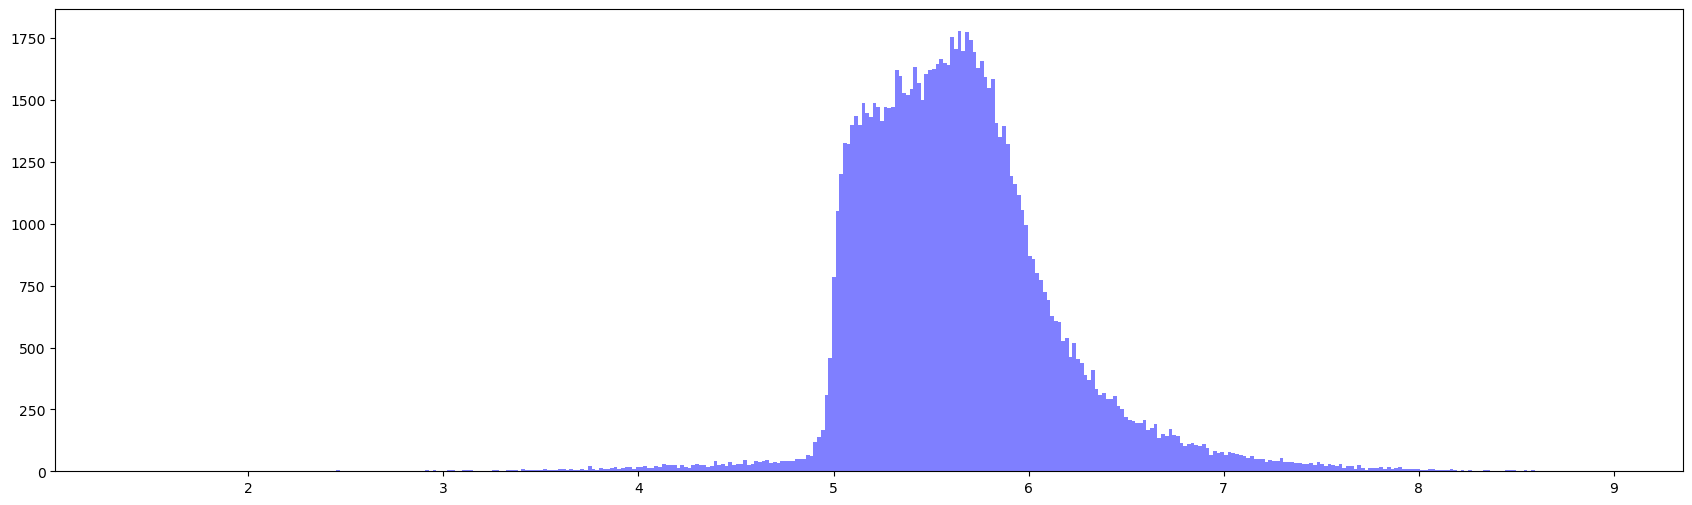

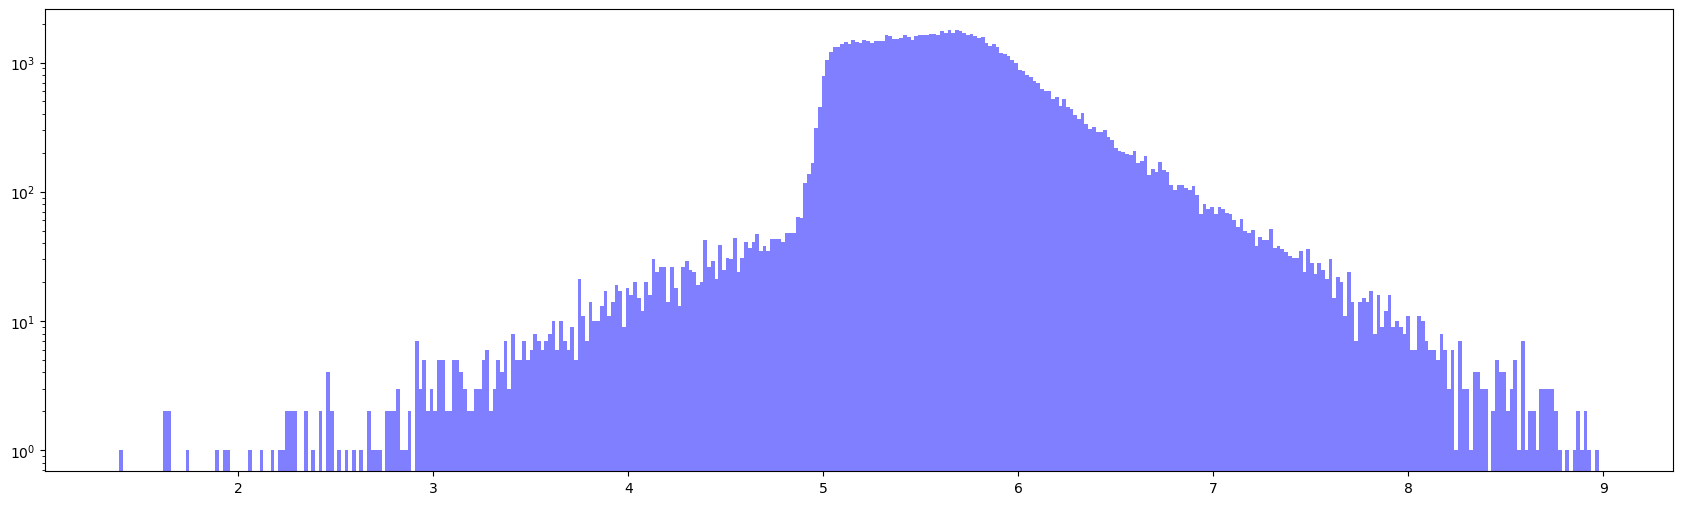

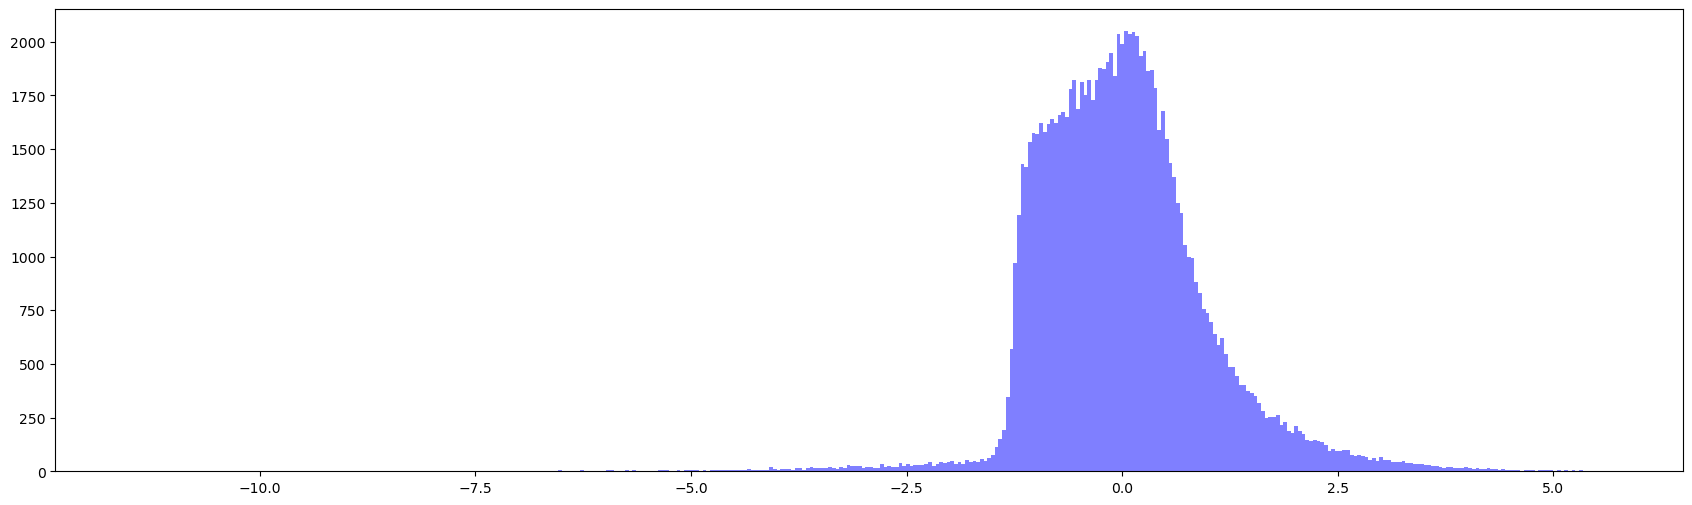

In [5]:
from sklearn.preprocessing import PowerTransformer

reshaped_shifted_eta = shifted_eta.reshape(-1, 1)

pt = PowerTransformer(method='box-cox')
pt.fit(reshaped_shifted_eta)
boxcox_eta = pt.transform(reshaped_shifted_eta)

# Plot the original vs transformed data
plt.hist(reshaped_shifted_eta, bins=400, alpha=0.5, label='Original shifted eta', color=anal.plotting.colors[0])
plt.show()

plt.yscale('log')
plt.hist(reshaped_shifted_eta, bins=400, alpha=0.5, label='Original shifted eta (log)', color=anal.plotting.colors[0])
plt.show()

plt.hist(boxcox_eta, bins=400, alpha=0.5, label='Box-Cox transformed eta', color=anal.plotting.colors[0])
plt.show()

In [ ]:
# from sklearn.preprocessing import PowerTransformer

# shifted_eta = shifted_eta.reshape(-1, 1)
# print(shifted_eta)

# pt = PowerTransformer(method='yeo-johnson')
# pt.fit(shifted_eta)
# yeojohnson_eta = pt.transform(shifted_eta)

# # Plot the original data
# plt.figure(figsize=(10, 5))

# # Plot the original vs transformed data
# plt.subplot(1, 2, 1)
# plt.scattereshaped_shifted_etata[:, 0]reshaped_shifted_etata[:, 1], color='blue', label='Original Data')
# plt.title('Original Data')
# plt.xlabel('Index')
# plt.ylabel('Value')

# # Plot the transformed data
# plt.subplot(1, 2, 2)
# plt.scatter(yeojohnson_eta[:, 0], yeojohnson_eta[:, 1], color='red', label='Transformed Data')
# plt.title('Transformed Data (Box-Cox)')
# plt.xlabel('Index')
# plt.ylabel('Transformed Value')

# # Show the plot
# plt.tight_layout()
# plt.show()

This is with the current linear tokenization.

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 1), (6, 0), (7, 0), (8, 3), (9, 1), (10, 1), (11, 0), (12, 3), (13, 0), (14, 2), (15, 1), (16, 7), (17, 3), (18, 3), (19, 7), (20, 2), (21, 4), (22, 5), (23, 7), (24, 13), (25, 13), (26, 16), (27, 15), (28, 12), (29, 18), (30, 23), (31, 25), (32, 28), (33, 38), (34, 32), (35, 54), (36, 53), (37, 63), (38, 69), (39, 89), (40, 99), (41, 94), (42, 102), (43, 126), (44, 140), (45, 143), (46, 172), (47, 174), (48, 220), (49, 562), (50, 3134), (51, 5790), (52, 6140), (53, 6255), (54, 6578), (55, 6638), (56, 6794), (57, 7044), (58, 7367), (59, 7240), (60, 6538), (61, 5564), (62, 4386), (63, 3419), (64, 2680), (65, 2153), (66, 1733), (67, 1345), (68, 1166), (69, 871), (70, 797), (71, 643), (72, 532), (73, 473), (74, 349), (75, 310), (76, 267), (77, 210), (78, 192), (79, 154), (80, 137), (81, 115), (82, 102), (83, 81), (84, 55), (85, 52), (86, 52), (87, 37), (88, 35), (89, 28), (90, 17), (91, 12), (92, 10), (93, 15), (94, 17), (95, 8), (96, 10), (97,

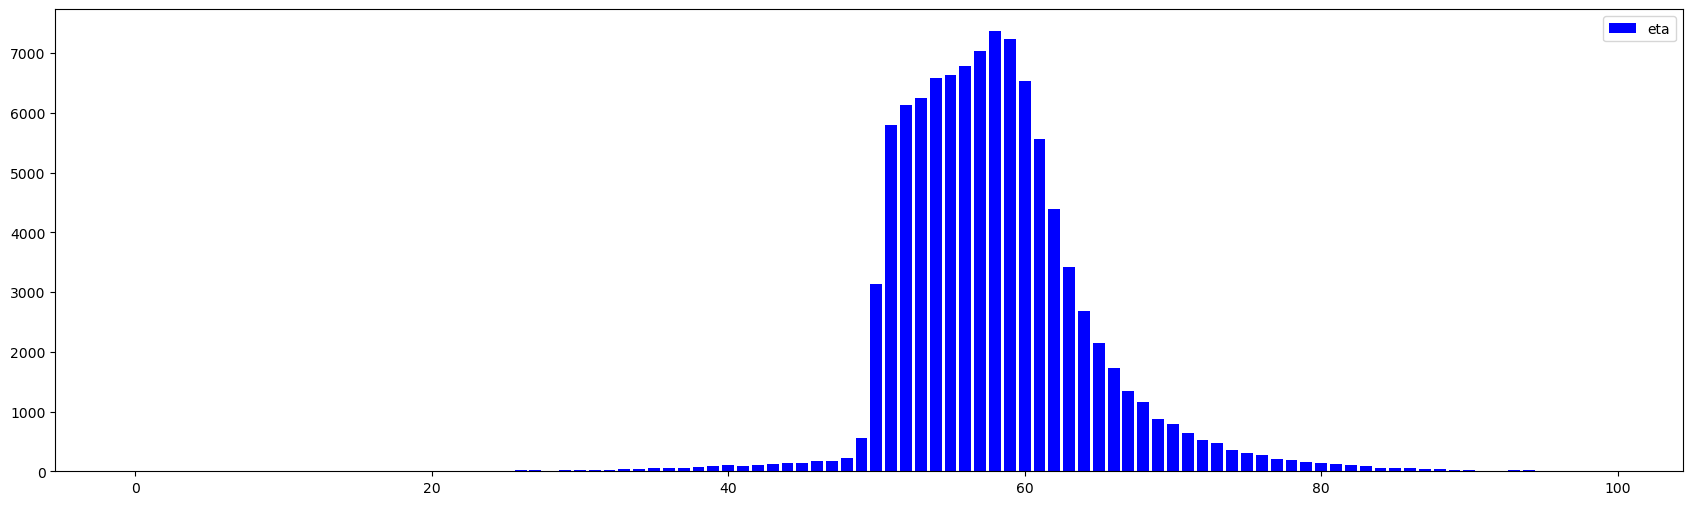

In [6]:
shifted_eta_bins = np.linspace(1, 9, 100)
tokenized_shifted_eta = np.digitize(shifted_eta, bins=shifted_eta_bins)
tokenized_shifted_eta_freq = Counter(tokenized_shifted_eta)
full_tokenized_freq = {i: 0 for i in range(0, 100)}
full_tokenized_freq.update(tokenized_shifted_eta_freq)
tokenized_shifted_eta_freq = sorted(full_tokenized_freq.items(), key=lambda x: x[0])

print(tokenized_shifted_eta_freq)
print(dict(tokenized_shifted_eta_freq))

plt.bar(np.arange(0, 100, 1), dict(tokenized_shifted_eta_freq).values(), label=f'eta', color=anal.plotting.colors[0])
plt.legend()

This is with log tokenization.

[1.7374687  1.64448261 1.83480778 ... 1.72844686 1.74022053 1.65016518]
[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 1), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 1), (23, 3), (24, 0), (25, 1), (26, 0), (27, 0), (28, 0), (29, 1), (30, 1), (31, 1), (32, 0), (33, 1), (34, 1), (35, 0), (36, 2), (37, 5), (38, 2), (39, 2), (40, 3), (41, 6), (42, 1), (43, 2), (44, 1), (45, 4), (46, 4), (47, 7), (48, 3), (49, 16), (50, 10), (51, 13), (52, 14), (53, 9), (54, 16), (55, 18), (56, 22), (57, 26), (58, 34), (59, 32), (60, 48), (61, 51), (62, 71), (63, 75), (64, 88), (65, 113), (66, 113), (67, 134), (68, 149), (69, 185), (70, 216), (71, 249), (72, 499), (73, 4269), (74, 8365), (75, 8918), (76, 9649), (77, 10111), (78, 11018), (79, 11371), (80, 9919), (81, 7228), (82, 4897), (83, 3401), (84, 2424), (85, 1669), (86, 1286), (87, 923), (88, 647), (89, 484), (90, 350), (91, 264), (92, 192), (93, 114), (

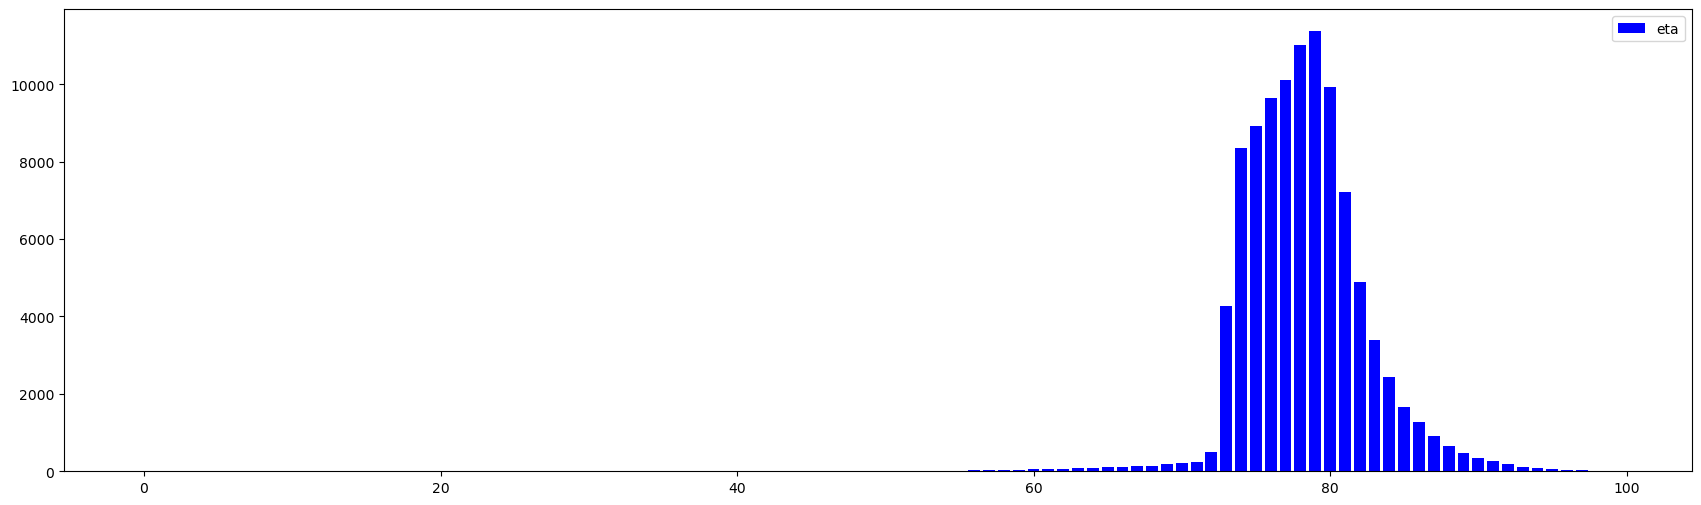

In [7]:
log_transformed_eta_bins = np.linspace(np.log(1), np.log(9), 100)
tokenized_log_transformed_eta = np.digitize(np.log(shifted_eta), bins=log_transformed_eta_bins)
tokenized_log_transformed_eta = Counter(tokenized_log_transformed_eta)
full_tokenized_freq = {i: 0 for i in range(0, 100)}
full_tokenized_freq.update(tokenized_log_transformed_eta)
tokenized_log_transformed_eta = sorted(full_tokenized_freq.items(), key=lambda x: x[0])

print(np.log(shifted_eta))

print(tokenized_log_transformed_eta)
print(dict(tokenized_log_transformed_eta))

plt.bar(np.arange(0, 100, 1), dict(tokenized_log_transformed_eta).values(), label=f'eta', color=anal.plotting.colors[0])
plt.legend()

This is with tanh tokenization.

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 1), (8, 0), (9, 0), (10, 2), (11, 2), (12, 1), (13, 0), (14, 0), (15, 3), (16, 0), (17, 1), (18, 1), (19, 1), (20, 6), (21, 4), (22, 1), (23, 7), (24, 2), (25, 2), (26, 3), (27, 3), (28, 6), (29, 7), (30, 13), (31, 8), (32, 14), (33, 15), (34, 8), (35, 16), (36, 13), (37, 21), (38, 22), (39, 25), (40, 30), (41, 27), (42, 45), (43, 40), (44, 50), (45, 63), (46, 60), (47, 82), (48, 88), (49, 81), (50, 99), (51, 112), (52, 116), (53, 133), (54, 165), (55, 156), (56, 186), (57, 252), (58, 945), (59, 4305), (60, 5840), (61, 6199), (62, 6261), (63, 6732), (64, 6812), (65, 7136), (66, 7443), (67, 7773), (68, 7299), (69, 6452), (70, 5282), (71, 3993), (72, 3094), (73, 2453), (74, 1949), (75, 1503), (76, 1239), (77, 978), (78, 787), (79, 708), (80, 550), (81, 408), (82, 375), (83, 291), (84, 231), (85, 201), (86, 174), (87, 137), (88, 102), (89, 77), (90, 68), (91, 50), (92, 42), (93, 33), (94, 19), (95, 19), (96, 18), (97, 17), (98, 

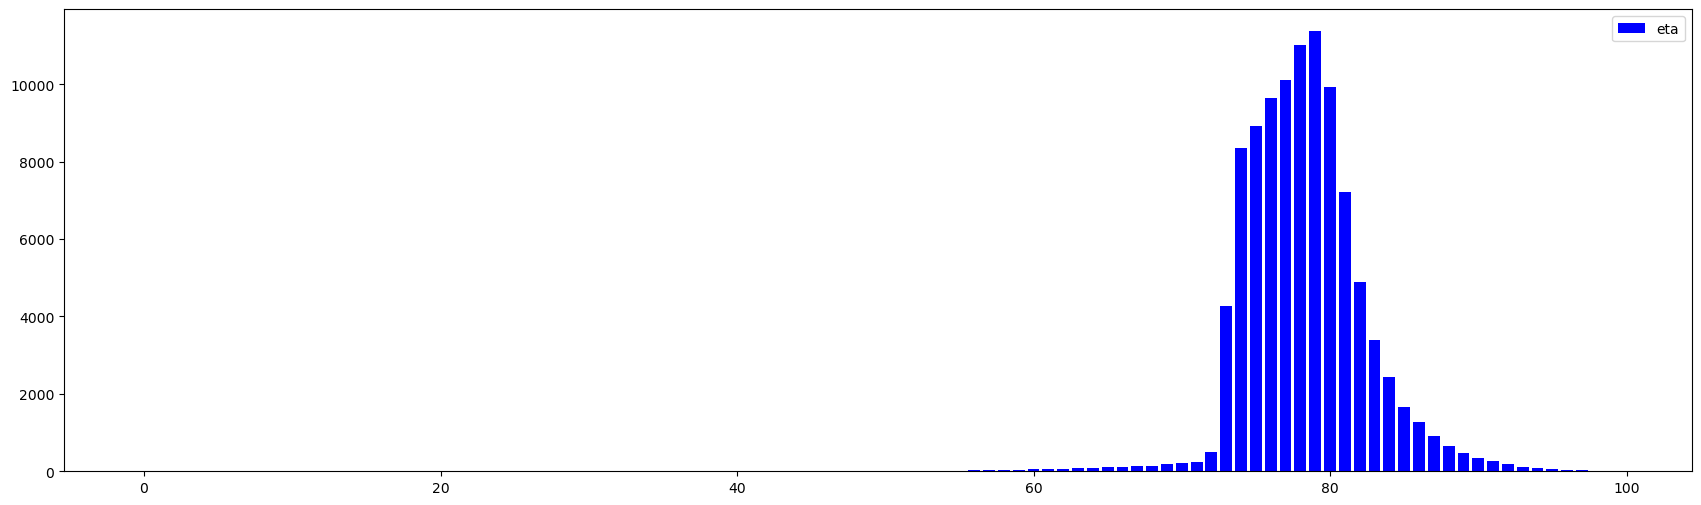

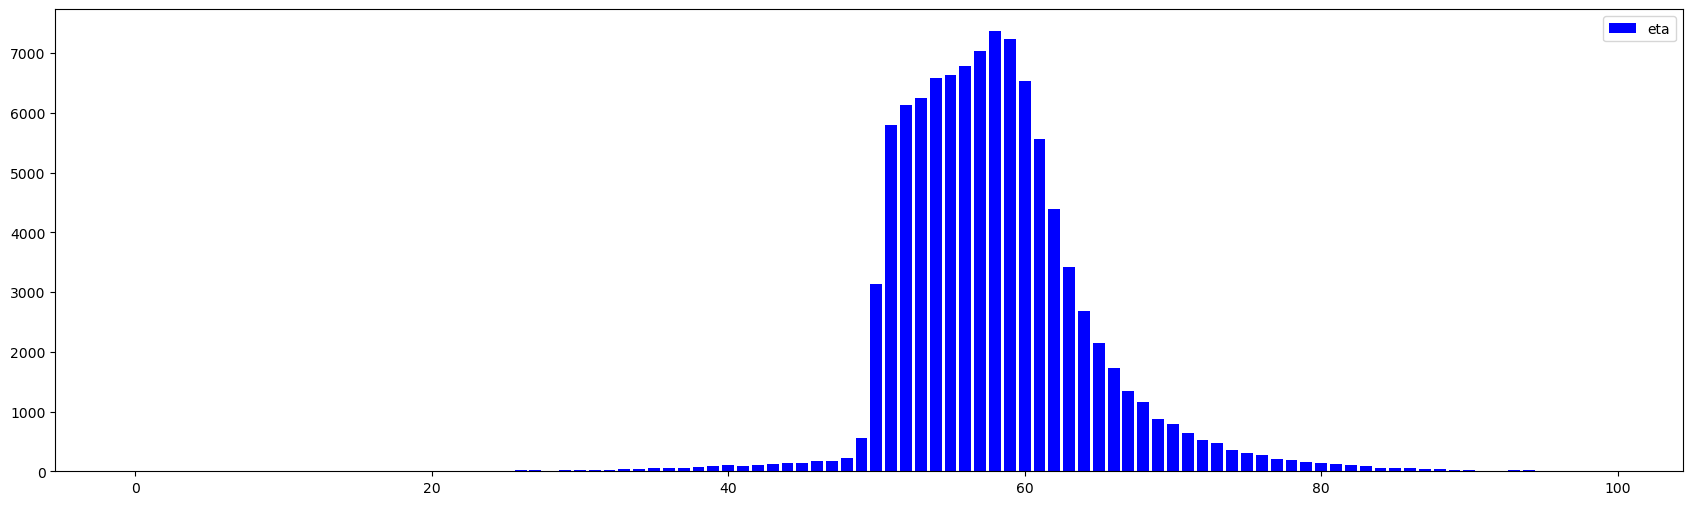

In [8]:
scale = 10
tanh_transformed_eta_bins = np.linspace(np.tanh(1 / scale), np.tanh(9 / scale), 100)
tokenized_tanh_transformed_eta = np.digitize(np.tanh(shifted_eta / scale), bins=tanh_transformed_eta_bins)
tokenized_tanh_transformed_eta = Counter(tokenized_tanh_transformed_eta)
full_tokenized_freq = {i: 0 for i in range(0, 100)}
full_tokenized_freq.update(tokenized_tanh_transformed_eta)
tokenized_tanh_transformed_eta = sorted(full_tokenized_freq.items(), key=lambda x: x[0])

print(tokenized_tanh_transformed_eta)
print(dict(tokenized_tanh_transformed_eta))

plt.bar(np.arange(0, 100, 1), dict(tokenized_log_transformed_eta).values(), label=f'eta', color=anal.plotting.colors[0])
plt.legend()
plt.show()

# Original linear for reference
shifted_eta_bins = np.linspace(1, 9, 100)
tokenized_shifted_eta = np.digitize(shifted_eta, bins=shifted_eta_bins)
tokenized_shifted_eta_freq = Counter(tokenized_shifted_eta)
full_tokenized_freq = {i: 0 for i in range(0, 100)}
full_tokenized_freq.update(tokenized_shifted_eta_freq)
tokenized_shifted_eta_freq = sorted(full_tokenized_freq.items(), key=lambda x: x[0])

plt.bar(np.arange(0, 100, 1), dict(tokenized_shifted_eta_freq).values(), label=f'eta', color=anal.plotting.colors[0])
plt.legend()
plt.show()

This is with arctan transformation.

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 1), (7, 0), (8, 0), (9, 0), (10, 3), (11, 1), (12, 1), (13, 0), (14, 1), (15, 2), (16, 0), (17, 2), (18, 1), (19, 3), (20, 5), (21, 2), (22, 3), (23, 7), (24, 1), (25, 2), (26, 4), (27, 5), (28, 6), (29, 11), (30, 12), (31, 13), (32, 16), (33, 8), (34, 17), (35, 12), (36, 21), (37, 22), (38, 25), (39, 31), (40, 27), (41, 45), (42, 42), (43, 54), (44, 62), (45, 62), (46, 88), (47, 89), (48, 88), (49, 90), (50, 119), (51, 125), (52, 140), (53, 163), (54, 166), (55, 191), (56, 343), (57, 1595), (58, 5111), (59, 6106), (60, 6207), (61, 6480), (62, 6737), (63, 6911), (64, 7255), (65, 7618), (66, 7652), (67, 7139), (68, 6012), (69, 4815), (70, 3689), (71, 2858), (72, 2296), (73, 1766), (74, 1440), (75, 1104), (76, 939), (77, 755), (78, 642), (79, 535), (80, 389), (81, 353), (82, 276), (83, 223), (84, 195), (85, 162), (86, 136), (87, 103), (88, 74), (89, 71), (90, 53), (91, 44), (92, 29), (93, 21), (94, 16), (95, 23), (96, 13), (97, 15), (9

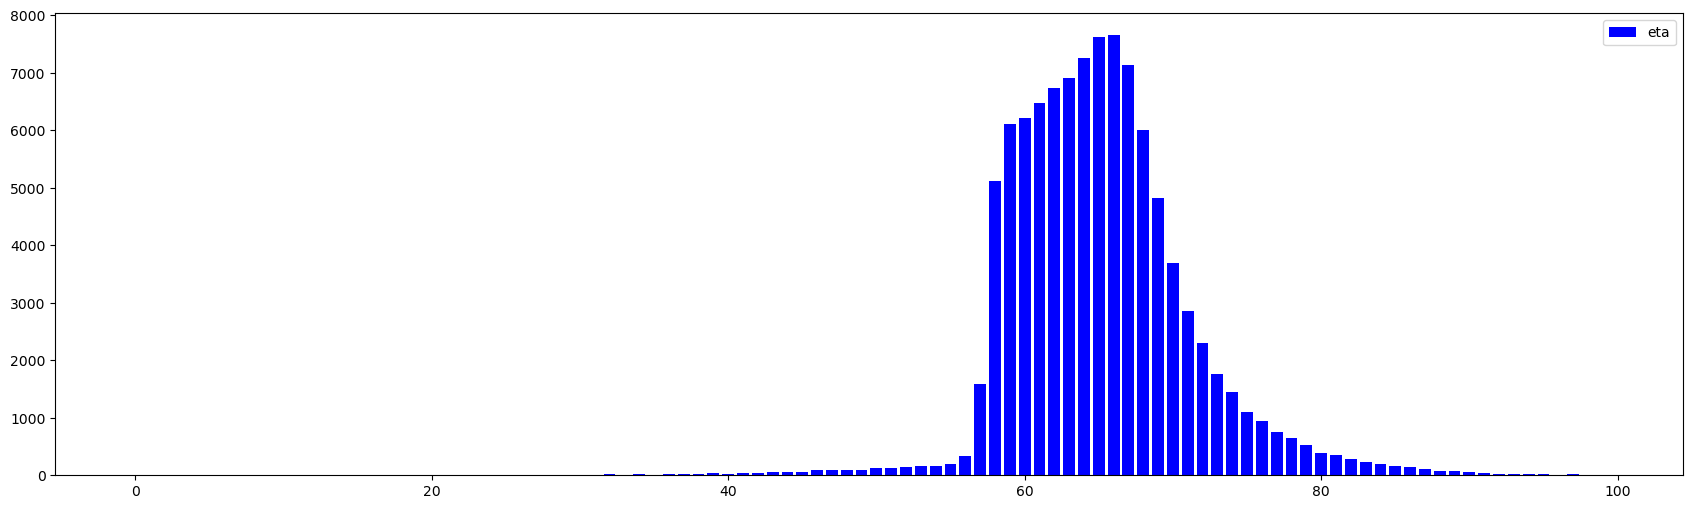

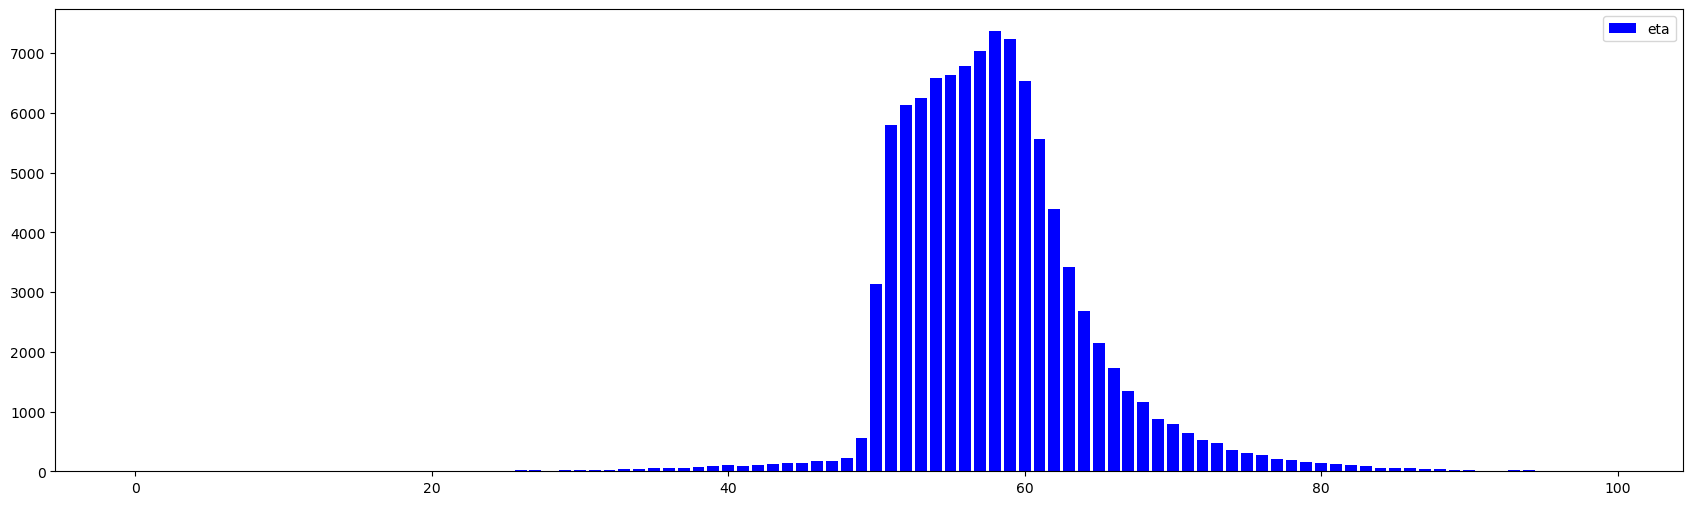

In [11]:
scale = 10
arctan_transformed_eta_bins = np.linspace(np.arctan(1 / scale) / (np.pi / 2), np.arctan(9 / scale) / (np.pi / 2), 100)
tokenized_arctan_transformed_eta = np.digitize(np.arctan(shifted_eta / scale) / (np.pi / 2), bins=arctan_transformed_eta_bins)
tokenized_arctan_transformed_eta = Counter(tokenized_arctan_transformed_eta)
full_tokenized_freq = {i: 0 for i in range(0, 100)}
full_tokenized_freq.update(tokenized_arctan_transformed_eta)
tokenized_arctan_transformed_eta = sorted(full_tokenized_freq.items(), key=lambda x: x[0])

print(tokenized_arctan_transformed_eta)
print(dict(tokenized_arctan_transformed_eta))

plt.bar(np.arange(0, 100, 1), dict(tokenized_arctan_transformed_eta).values(), label=f'eta', color=anal.plotting.colors[0])
plt.legend()
plt.show()

# Original linear for reference
shifted_eta_bins = np.linspace(1, 9, 100)
tokenized_shifted_eta = np.digitize(shifted_eta, bins=shifted_eta_bins)
tokenized_shifted_eta_freq = Counter(tokenized_shifted_eta)
full_tokenized_freq = {i: 0 for i in range(0, 100)}
full_tokenized_freq.update(tokenized_shifted_eta_freq)
tokenized_shifted_eta_freq = sorted(full_tokenized_freq.items(), key=lambda x: x[0])

plt.bar(np.arange(0, 100, 1), dict(tokenized_shifted_eta_freq).values(), label=f'eta', color=anal.plotting.colors[0])
plt.legend()
plt.show()

This is with quantile transformation.

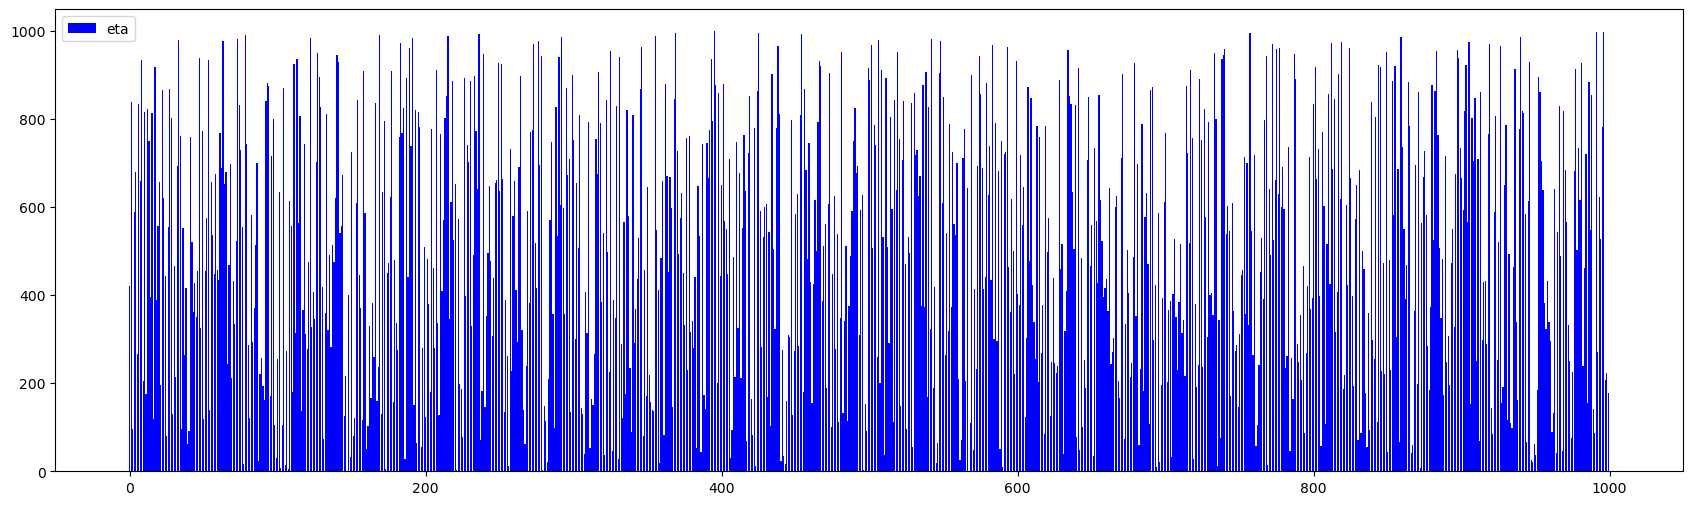

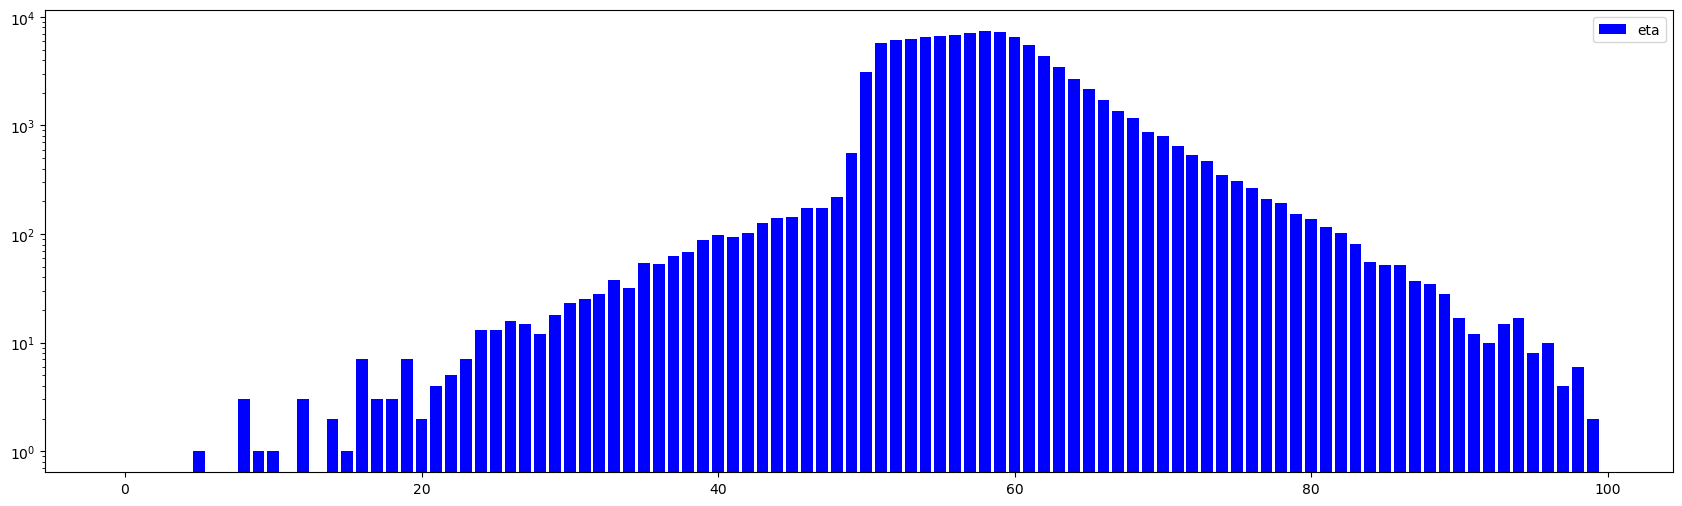

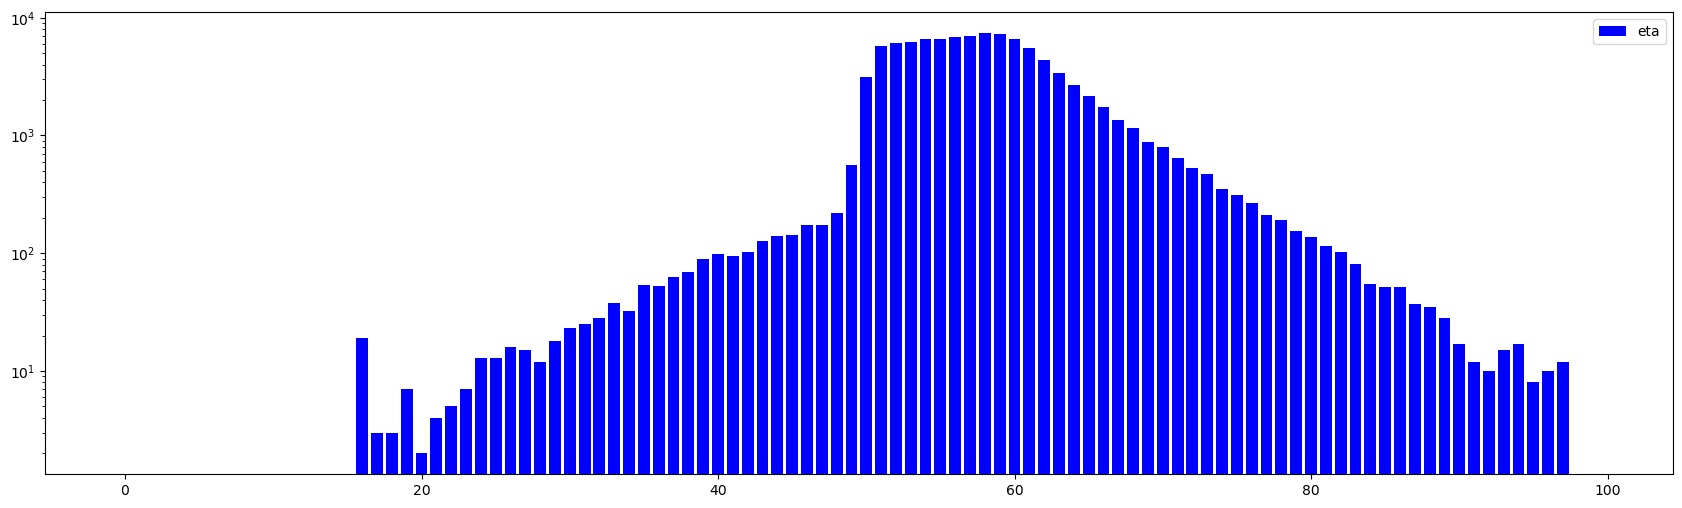

In [12]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution="uniform", n_quantiles=10000)
quan_eta_transformed = qt.fit_transform(shifted_eta.reshape(-1, 1)).flatten()
reversed_quan_eta_transformed = qt.inverse_transform(quan_eta_transformed.reshape(-1, 1)).flatten()

# Scale to tokenization range
max_token = 0
min_token = 999
quan_token_eta = (quan_eta_transformed * (max_token - min_token) + min_token).astype(int)

plt.bar(np.arange(0, 1000, 1), Counter(quan_token_eta), label=f'eta', color=anal.plotting.colors[0])
plt.legend()
plt.show()

# Original shifted eta
shifted_eta_bins = np.linspace(1, 9, 100)
tokenized_shifted_eta = np.digitize(shifted_eta, bins=shifted_eta_bins)
tokenized_shifted_eta_freq = Counter(tokenized_shifted_eta)
full_tokenized_freq = {i: 0 for i in range(0, 100)}
full_tokenized_freq.update(tokenized_shifted_eta_freq)
tokenized_shifted_eta_freq = sorted(full_tokenized_freq.items(), key=lambda x: x[0])

plt.yscale("log")
plt.bar(np.arange(0, 100, 1), dict(tokenized_shifted_eta_freq).values(), label=f'eta', color=anal.plotting.colors[0])
plt.legend()
plt.show()

# Reconstructed shifted eta
shifted_eta_bins = np.linspace(1, 9, 100)
tokenized_shifted_eta = np.digitize(reversed_quan_eta_transformed, bins=shifted_eta_bins)
tokenized_shifted_eta_freq = Counter(tokenized_shifted_eta)
full_tokenized_freq = {i: 0 for i in range(0, 100)}
full_tokenized_freq.update(tokenized_shifted_eta_freq)
tokenized_shifted_eta_freq = sorted(full_tokenized_freq.items(), key=lambda x: x[0])

plt.yscale("log")
plt.bar(np.arange(0, 100, 1), dict(tokenized_shifted_eta_freq).values(), label=f'eta', color=anal.plotting.colors[0])
plt.legend()
plt.show()

This is with quantile TOKENIZATION.

[4628 1257 7233 ... 4253 4746 1437]


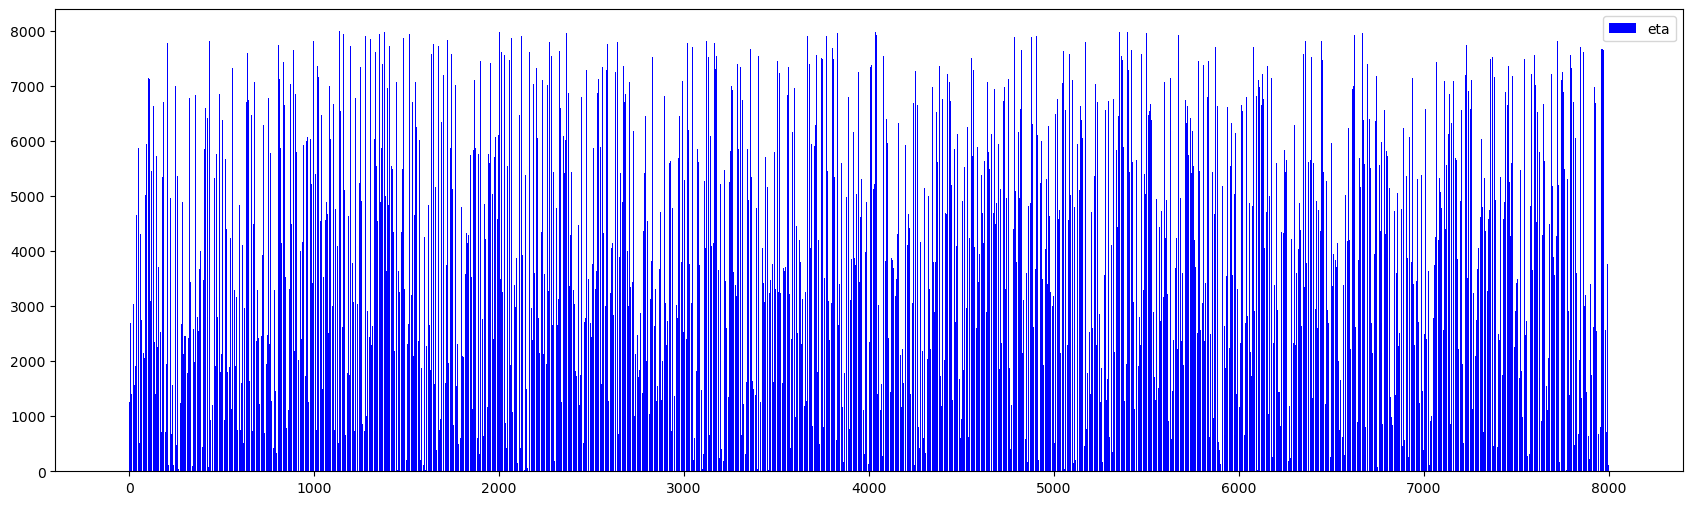

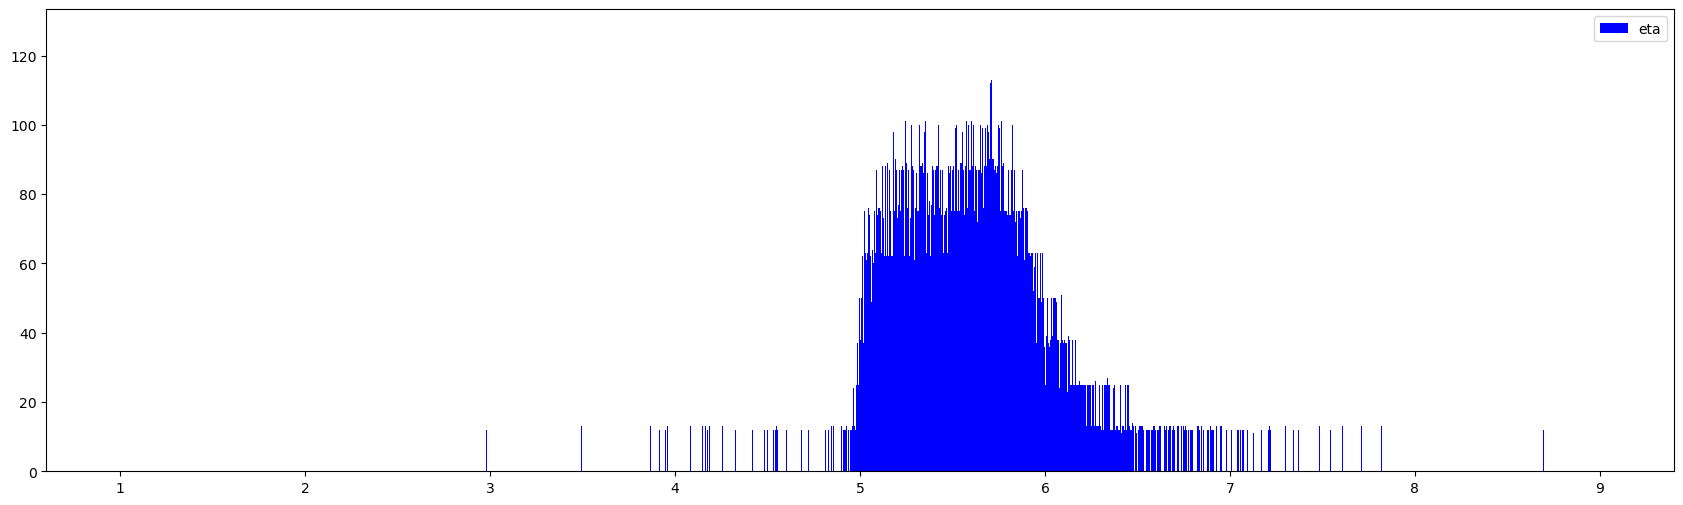

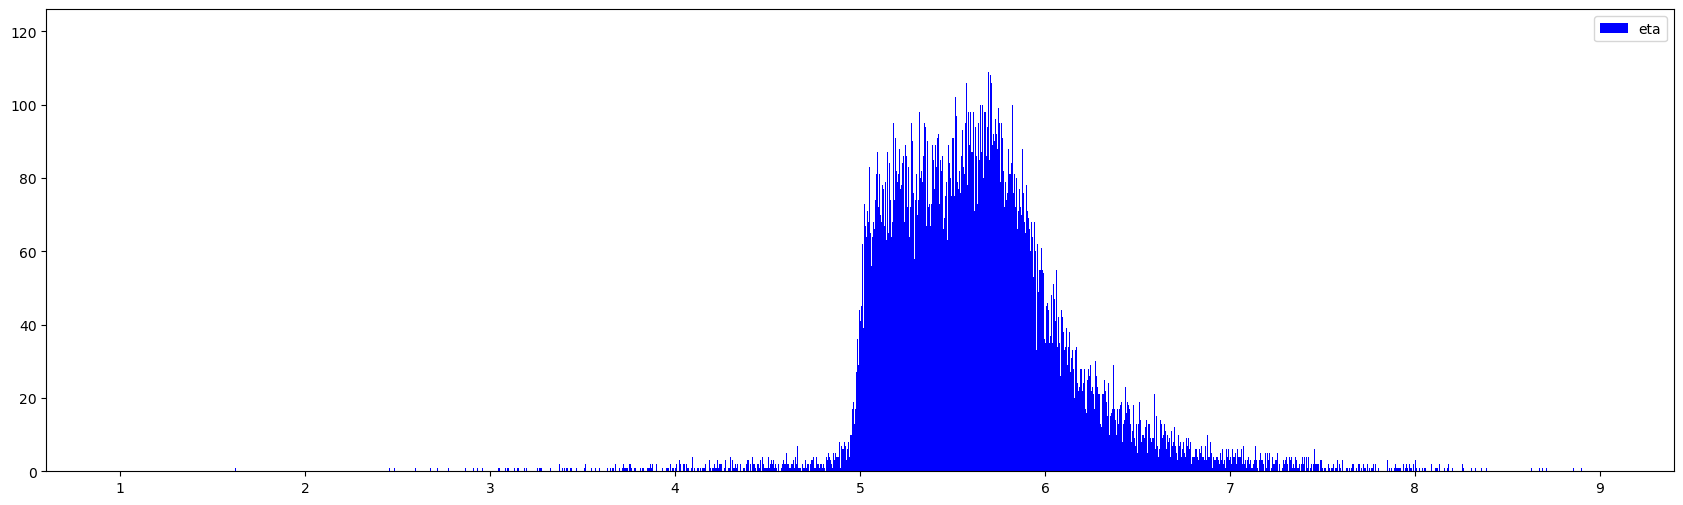

In [13]:
def quantile_tokenizer(eta_values, num_bins=8001, token_min=0):
    # Compute bin edges so that each bin has equal count
    bin_edges = np.quantile(eta_values, q=np.linspace(0, 1, num_bins + 1))
    # Digitize each eta value
    bin_indices = np.digitize(eta_values, bin_edges[1:-1], right=True)
    # Map to token range
    tokens = token_min + bin_indices
    return tokens, bin_edges

def detokenize_eta(tokens, bin_edges, token_min=0):
    indices = tokens - token_min
    # Return center of each bin
    eta_reconstructed = 0.5 * (bin_edges[indices] + bin_edges[indices + 1])
    return eta_reconstructed

quantized_tokens, quantized_bin_edges = quantile_tokenizer(shifted_eta, num_bins=8000)
print(quantized_tokens)

plt.bar(np.arange(0, 8000, 1), Counter(quantized_tokens), label=f'eta', color=anal.plotting.colors[0])
plt.legend()
plt.show()

dequantized_tokens = detokenize_eta(quantized_tokens, quantized_bin_edges)

plt.hist(dequantized_tokens, range=(1, 9), bins=8000, label=f'eta', color=anal.plotting.colors[0])
plt.legend()
plt.show()

plt.hist(shifted_eta, range=(1, 9), bins=8000, label=f'eta', color=anal.plotting.colors[0])
plt.legend()
plt.show()

This is with signed log transformation.

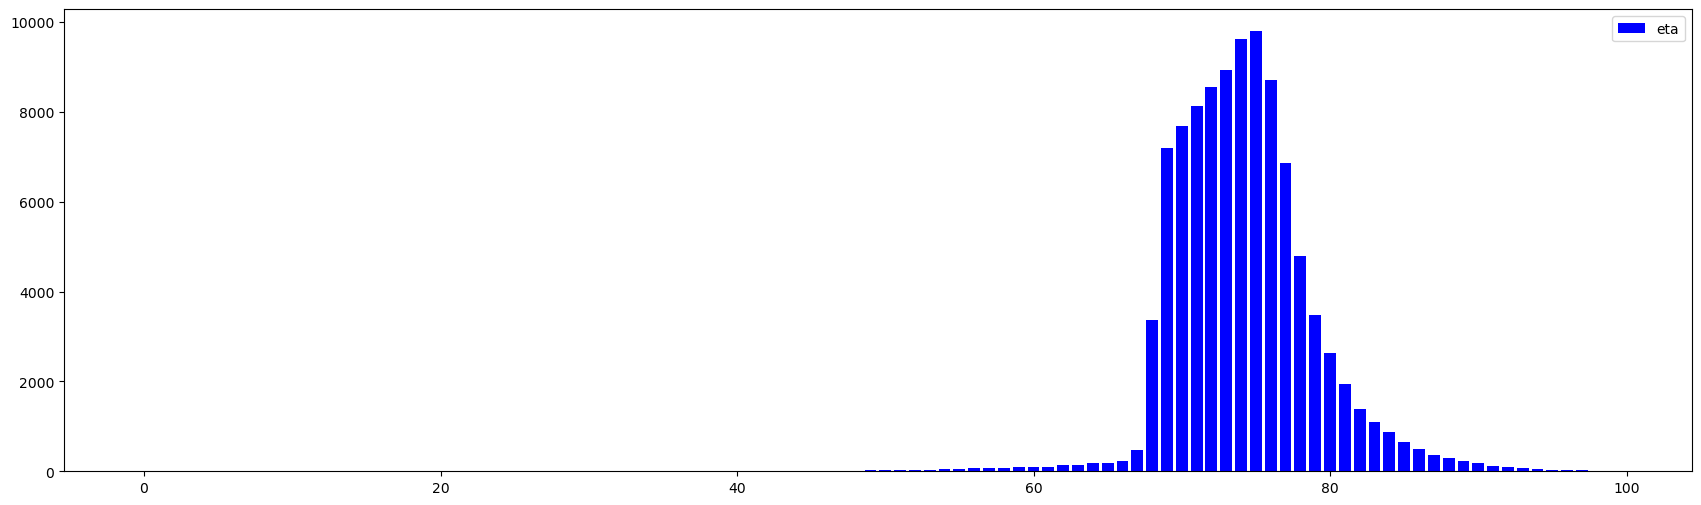

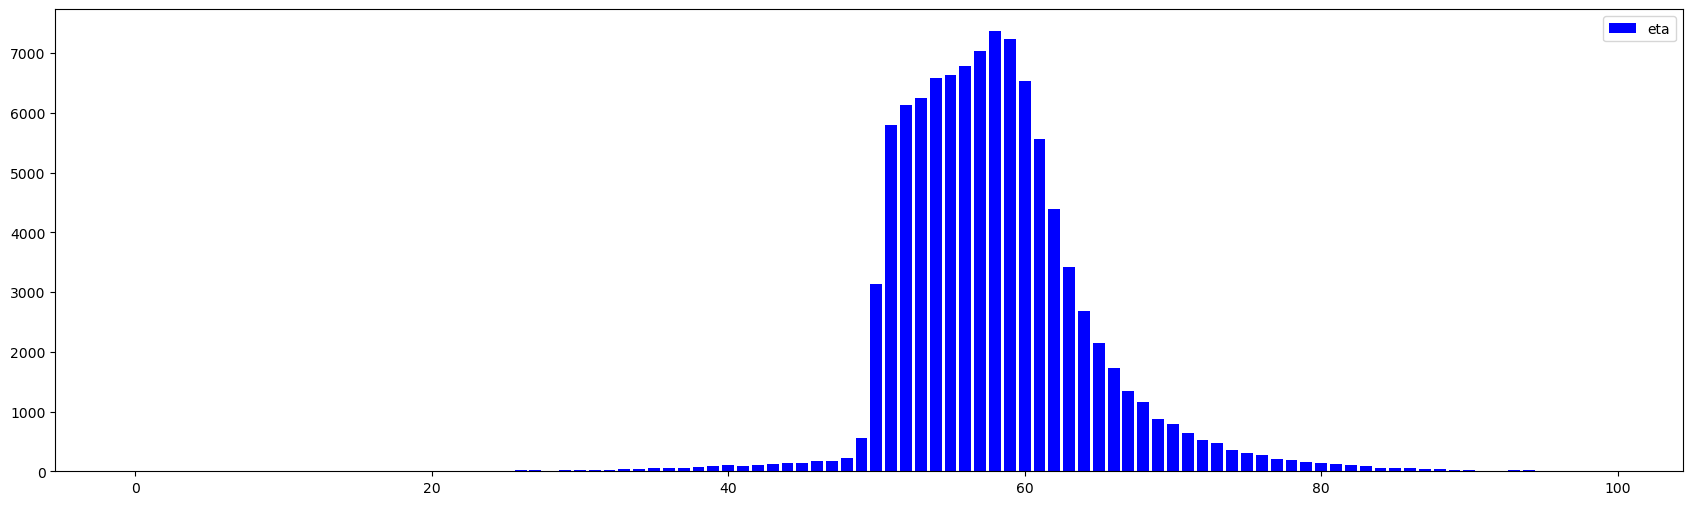

In [14]:
def signed_log_eta(eta):
    return np.sign(eta) * np.log1p(np.abs(eta))

def inverse_signed_log_eta(x):
    return np.sign(x) * (np.expm1(np.abs(x)))

signed_log_transformed_eta = signed_log_eta(shifted_eta)
tokenized_signed_log_bins = np.linspace(np.log1p(1), np.log1p(9), 100)
tokenized_signed_log_eta = np.digitize(signed_log_transformed_eta, bins=tokenized_signed_log_bins)
tokenized_signed_log_eta = Counter(tokenized_signed_log_eta)
full_tokenized_freq = {i: 0 for i in range(0, 100)}
full_tokenized_freq.update(tokenized_signed_log_eta)
tokenized_signed_log_eta = sorted(full_tokenized_freq.items(), key=lambda x: x[0])

plt.bar(np.arange(0, 100, 1), dict(tokenized_signed_log_eta).values(), label=f'eta', color=anal.plotting.colors[0])
plt.legend()
plt.show()

# Original shifted eta
shifted_eta_bins = np.linspace(1, 9, 100)
tokenized_shifted_eta = np.digitize(shifted_eta, bins=shifted_eta_bins)
tokenized_shifted_eta_freq = Counter(tokenized_shifted_eta)
full_tokenized_freq = {i: 0 for i in range(0, 100)}
full_tokenized_freq.update(tokenized_shifted_eta_freq)
tokenized_shifted_eta_freq = sorted(full_tokenized_freq.items(), key=lambda x: x[0])

plt.bar(np.arange(0, 100, 1), dict(tokenized_shifted_eta_freq).values(), label=f'eta', color=anal.plotting.colors[0])
plt.legend()
plt.show()

(100000, 10)
(97683, 10)


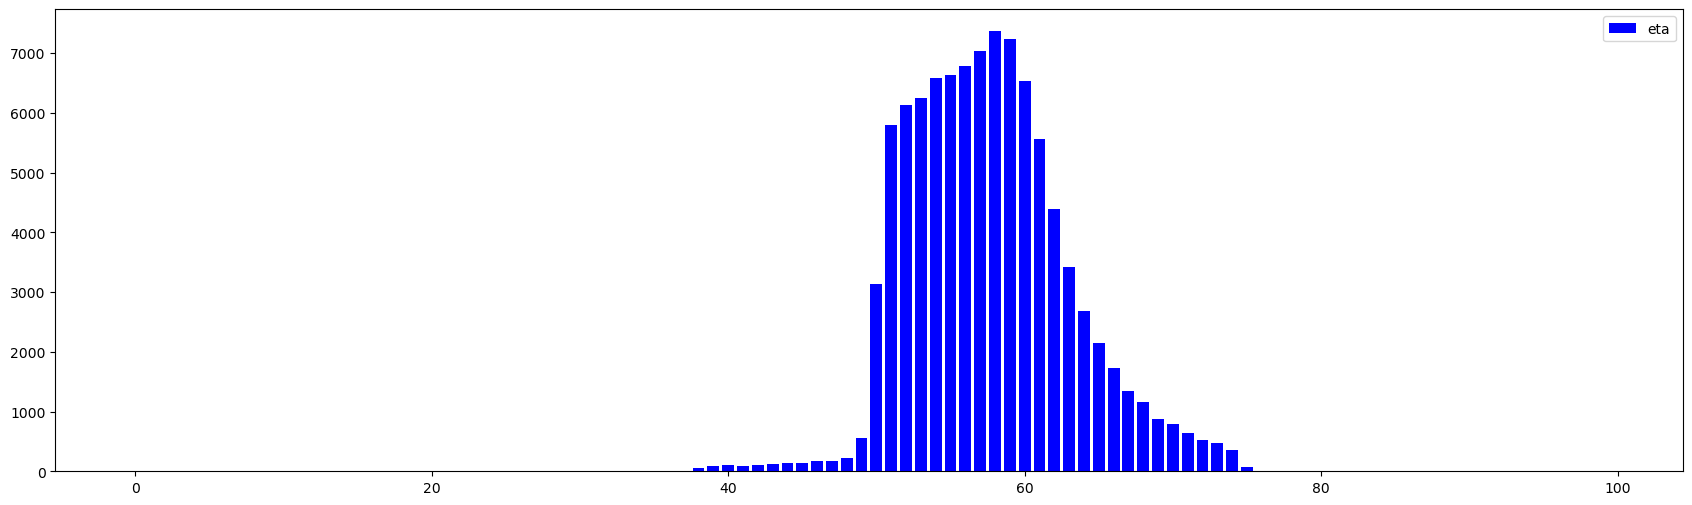

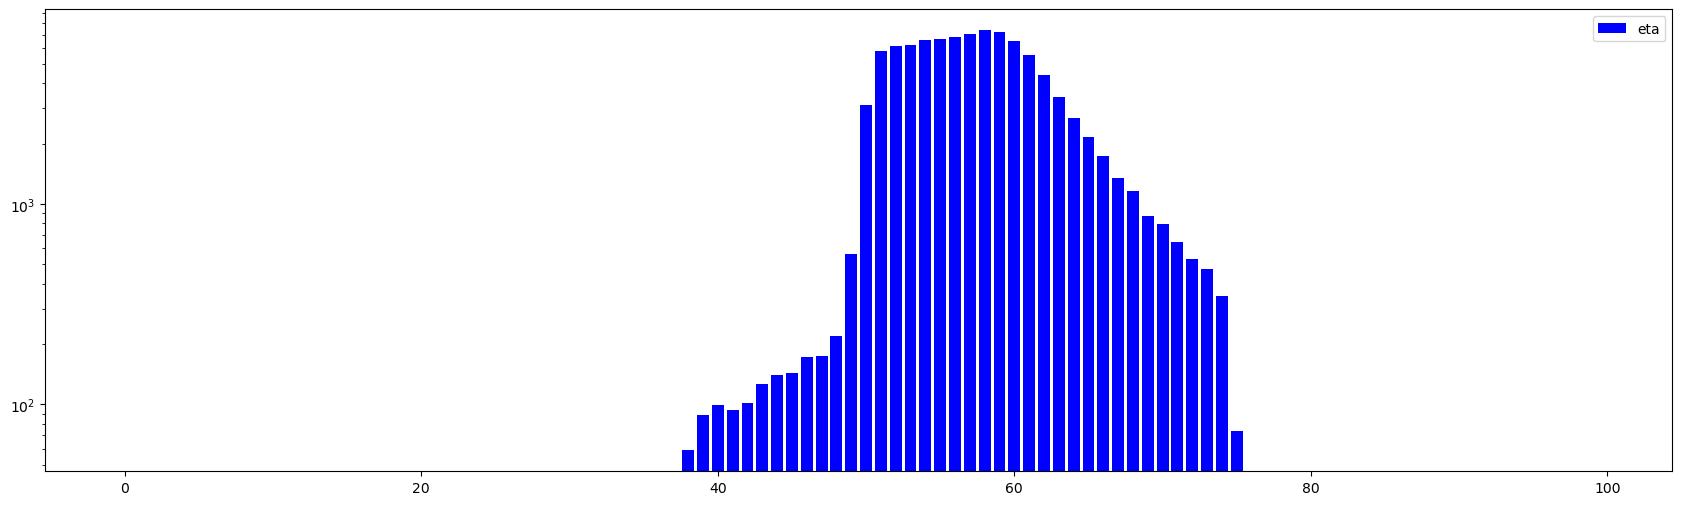

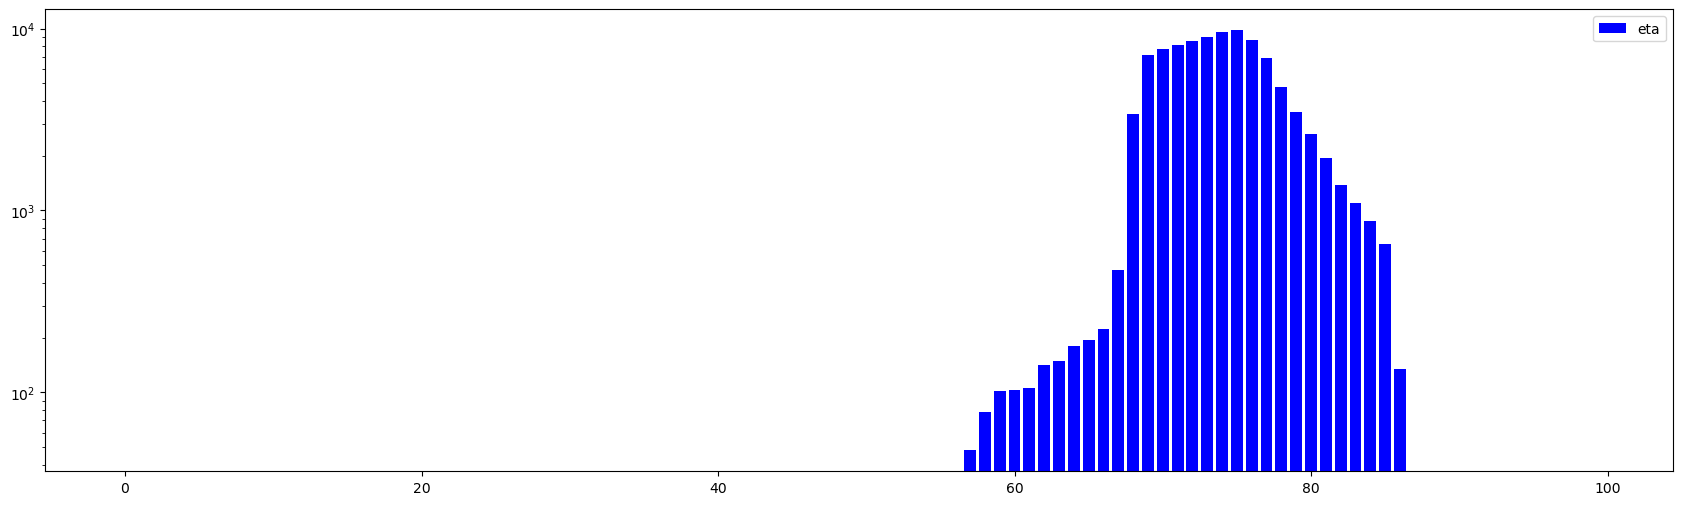

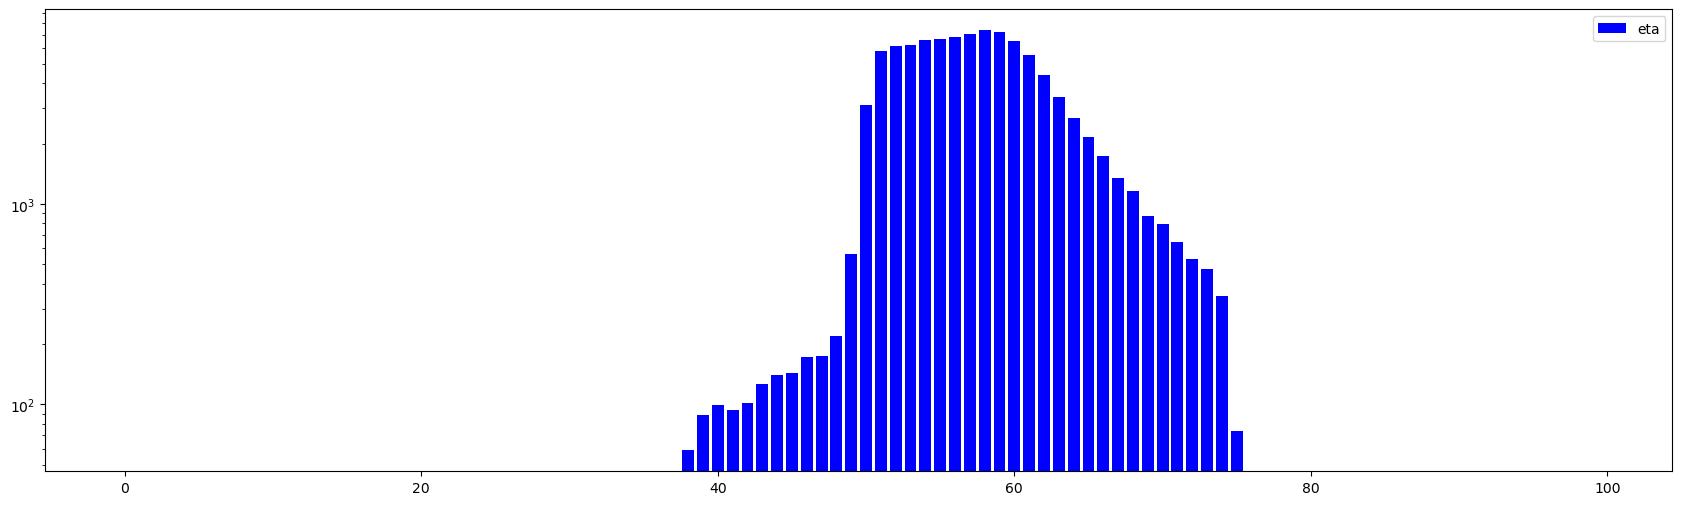

In [15]:
restricted_eta_df = real_df[(real_df['eta'] > -1) & (real_df['eta'] < 2)]
print(real_df.shape)
print(restricted_eta_df.shape)

shifted_eta = restricted_eta_df['eta'].to_numpy() + 5

shifted_eta_bins = np.linspace(1, 9, 100)
tokenized_shifted_eta = np.digitize(shifted_eta, bins=shifted_eta_bins)
tokenized_shifted_eta_freq = Counter(tokenized_shifted_eta)
full_tokenized_freq = {i: 0 for i in range(0, 100)}
full_tokenized_freq.update(tokenized_shifted_eta_freq)
tokenized_shifted_eta_freq = sorted(full_tokenized_freq.items(), key=lambda x: x[0])

plt.bar(np.arange(0, 100, 1), dict(tokenized_shifted_eta_freq).values(), label=f'eta', color=anal.plotting.colors[0])
plt.legend()
plt.show()

plt.yscale("log")
plt.bar(np.arange(0, 100, 1), dict(tokenized_shifted_eta_freq).values(), label=f'eta', color=anal.plotting.colors[0])
plt.legend()
plt.show()


def signed_log_eta(eta):
    return np.sign(eta) * np.log1p(np.abs(eta))

def inverse_signed_log_eta(x):
    return np.sign(x) * (np.expm1(np.abs(x)))

signed_log_transformed_eta = signed_log_eta(shifted_eta)
tokenized_signed_log_bins = np.linspace(np.log1p(1), np.log1p(9), 100)
tokenized_signed_log_eta = np.digitize(signed_log_transformed_eta, bins=tokenized_signed_log_bins)
tokenized_signed_log_eta = Counter(tokenized_signed_log_eta)
full_tokenized_freq = {i: 0 for i in range(0, 100)}
full_tokenized_freq.update(tokenized_signed_log_eta)
tokenized_signed_log_eta = sorted(full_tokenized_freq.items(), key=lambda x: x[0])

plt.yscale("log")
plt.bar(np.arange(0, 100, 1), dict(tokenized_signed_log_eta).values(), label=f'eta', color=anal.plotting.colors[0])
plt.legend()
plt.show()

# Original shifted eta
shifted_eta_bins = np.linspace(1, 9, 100)
tokenized_shifted_eta = np.digitize(shifted_eta, bins=shifted_eta_bins)
tokenized_shifted_eta_freq = Counter(tokenized_shifted_eta)
full_tokenized_freq = {i: 0 for i in range(0, 100)}
full_tokenized_freq.update(tokenized_shifted_eta_freq)
tokenized_shifted_eta_freq = sorted(full_tokenized_freq.items(), key=lambda x: x[0])

plt.yscale("log")
plt.bar(np.arange(0, 100, 1), dict(tokenized_shifted_eta_freq).values(), label=f'eta', color=anal.plotting.colors[0])
plt.legend()
plt.show()

This is a pt inspired attempt at quantile transformation.

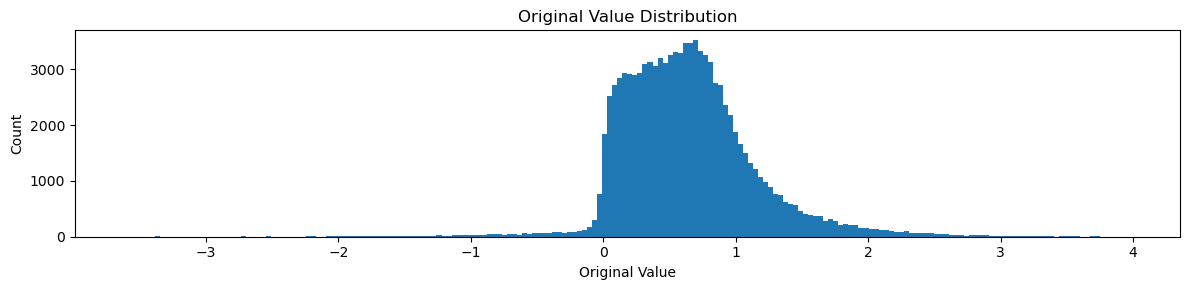

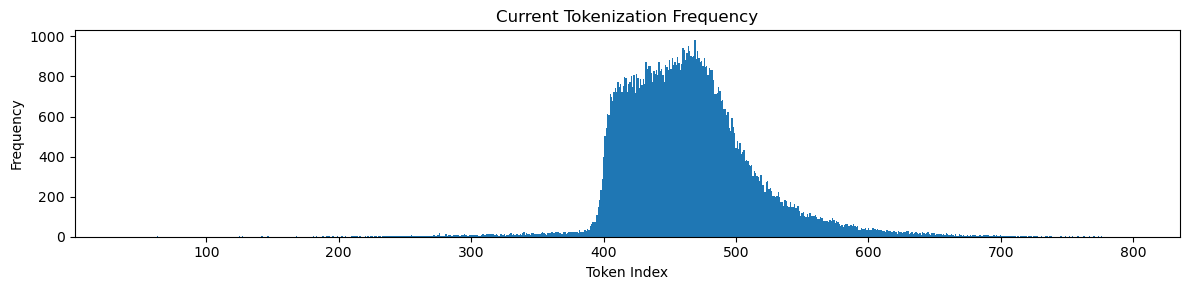

In [16]:
original_values = real_df['eta']

current_bins = np.linspace(-4, 4, 800)
current_tokens = np.digitize(original_values, current_bins, right=False)

def plot_token_freq(tokens, title):
    counts = Counter(tokens)
    keys = sorted(counts.keys())
    values = [counts[k] for k in keys]
    plt.figure(figsize=(12, 3))
    plt.bar(keys, values, width=1.0)
    plt.title(title)
    plt.xlabel("Token Index")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    
plt.figure(figsize=(12, 3))
plt.hist(original_values, bins=200)
plt.title("Original Value Distribution")
plt.xlabel("Original Value")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plot_token_freq(current_tokens, "Current Tokenization Frequency")

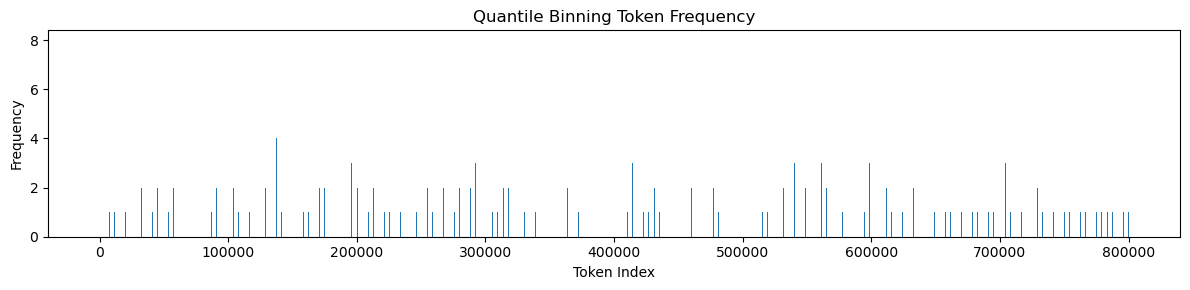

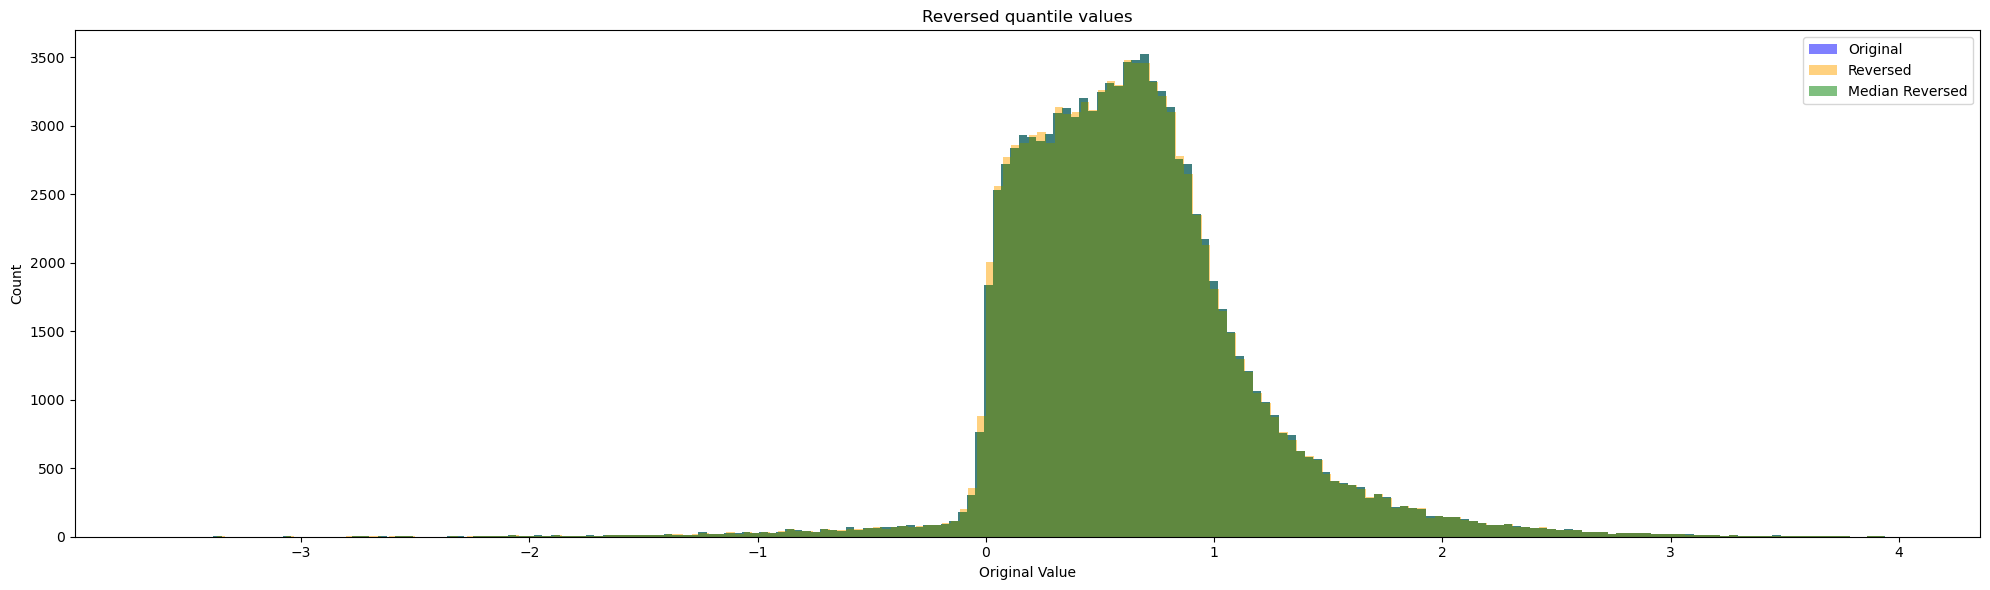

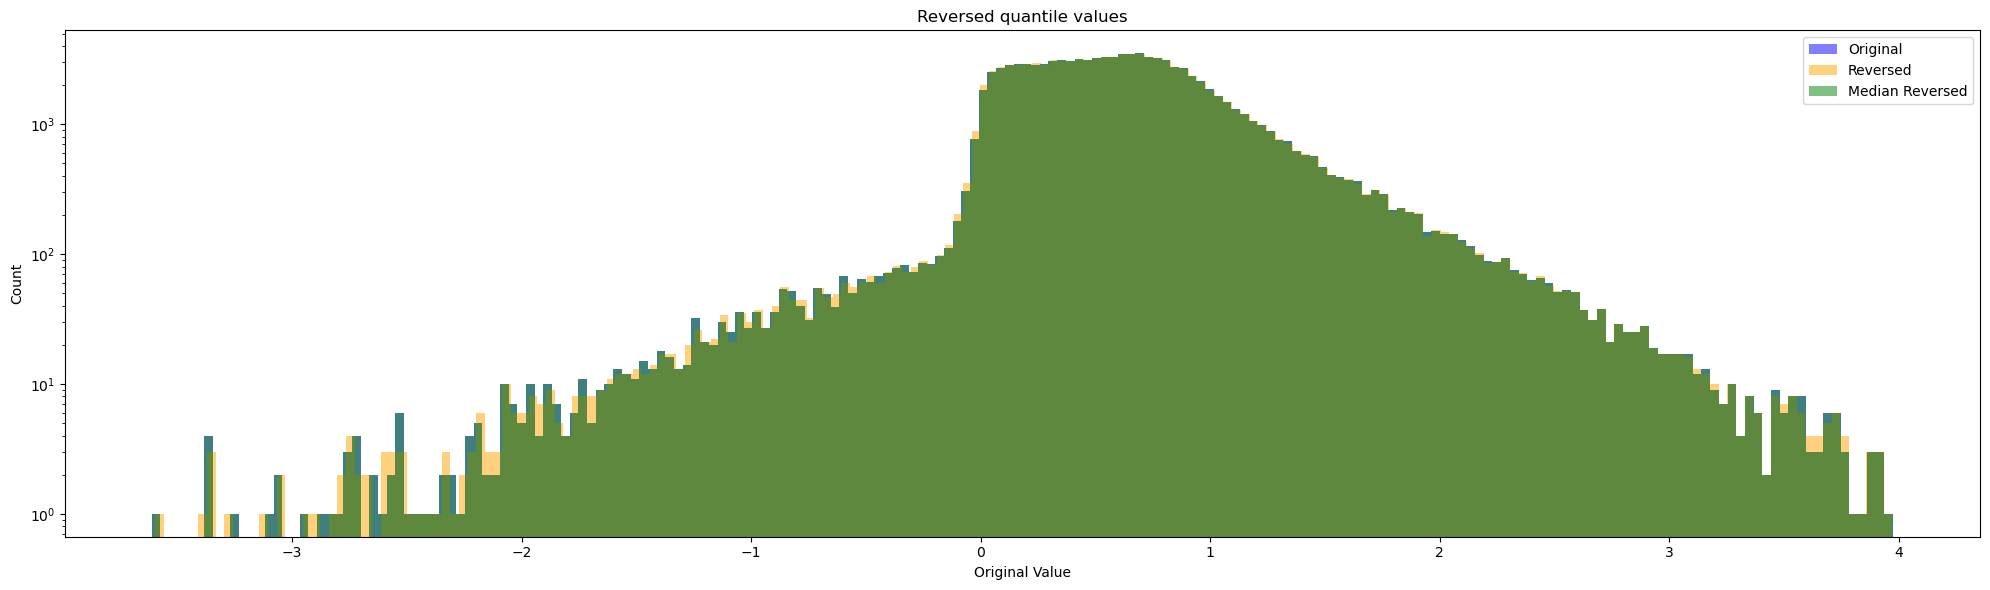

In [17]:
def quantile_tokenizer(values, num_bins=350, token_min=0):
    bin_edges = np.quantile(values, q=np.linspace(0, 1, num_bins + 1))
    bin_indices = np.digitize(values, bin_edges[1:-1], right=True)
    tokens = token_min + bin_indices
    return tokens, bin_edges

def quantile_detokenize(tokens, bin_edges, token_min=0):
    indices = tokens - token_min
    # Clip just in case
    indices = np.clip(indices, 0, len(bin_edges) - 2)
    # Use bin centers (can replace with per-bin means for more precision)
    return 0.5 * (bin_edges[indices] + bin_edges[indices + 1])

def build_bin_means(values, bin_edges):
    bin_indices = np.digitize(values, bin_edges[1:-1], right=True)
    bin_means = np.zeros(len(bin_edges) - 1)
    for i in range(len(bin_means)):
        in_bin = values[bin_indices == i]
        bin_means[i] = in_bin.mean() if len(in_bin) > 0 else 0.5 * (bin_edges[i] + bin_edges[i + 1])
    return bin_means

n_quan_bins = 800000
quantile_tokens, quantile_edges = quantile_tokenizer(original_values, num_bins=n_quan_bins)
reversed_quantile_values = quantile_detokenize(quantile_tokens, quantile_edges)

mean_per_bin = build_bin_means(original_values, quantile_edges)
reconstructed_eta = mean_per_bin[quantile_tokens - 0]

plot_token_freq(quantile_tokens, "Quantile Binning Token Frequency")

plt.figure(figsize=(20, 6))
plt.hist(original_values, bins=200, color='blue', alpha=0.5)
plt.hist(reversed_quantile_values, bins=200, color='orange', alpha=0.5)
plt.hist(reconstructed_eta, bins=200, color='green', alpha=0.5)
plt.title("Reversed quantile values")
plt.xlabel("Original Value")
plt.ylabel("Count")
plt.legend(['Original', 'Reversed', 'Median Reversed'])
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 6))
plt.yscale('log')
plt.hist(original_values, bins=200, color='blue', alpha=0.5)
plt.hist(reversed_quantile_values, bins=200, color='orange', alpha=0.5)
plt.hist(reconstructed_eta, bins=200, color='green', alpha=0.5)
plt.title("Reversed quantile values")
plt.xlabel("Original Value")
plt.ylabel("Count")
plt.legend(['Original', 'Reversed', 'Median Reversed'])
plt.tight_layout()
plt.show()

Much like pt, I am testing if binning the quantile binning will work.

This is the ideal. This is what we want to achieve with training.


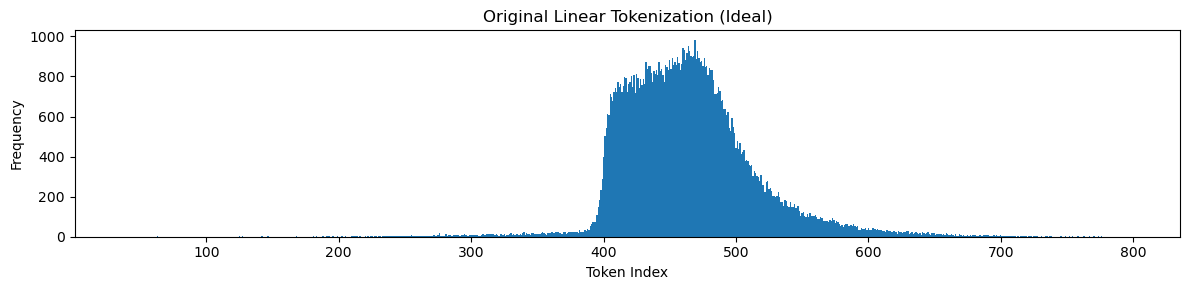

This the the quantile tokens (n_bins=800000) binned into 8000 bins.


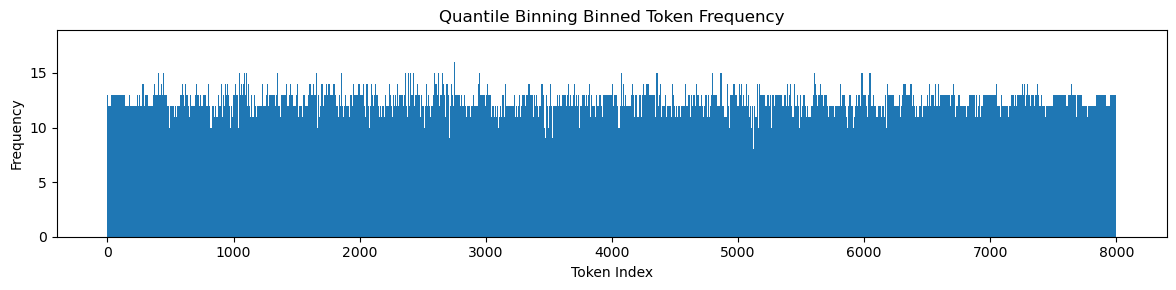

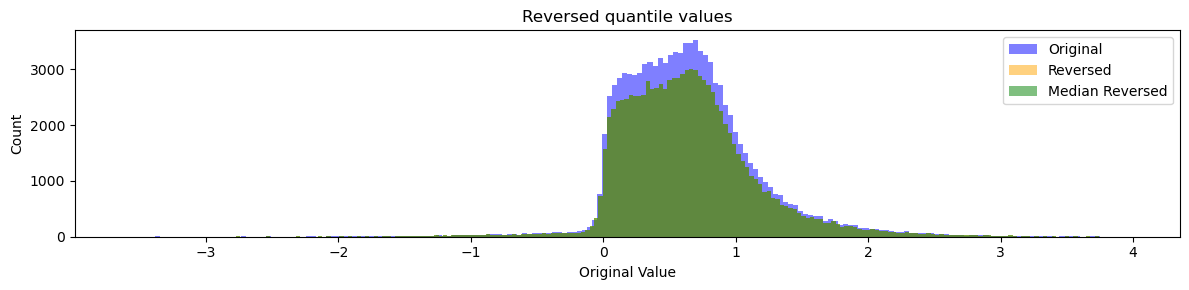

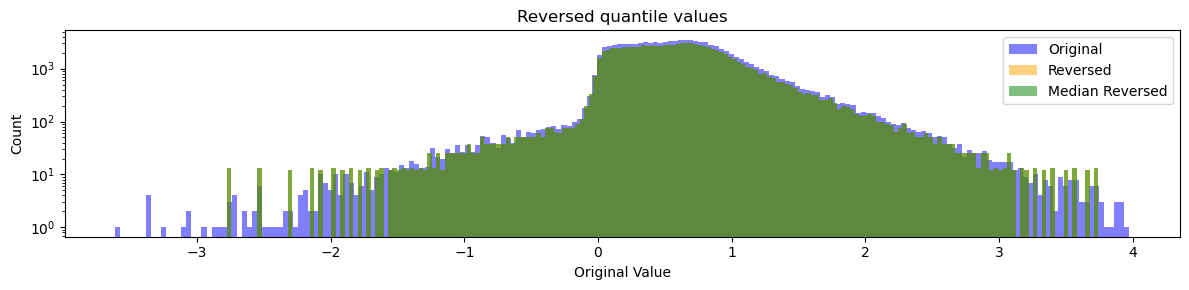

In [19]:
print("This is the ideal. This is what we want to achieve with training.")
plot_token_freq(current_tokens, "Original Linear Tokenization (Ideal)")

# print(quan_bin_bin_tokenized, quan_bin_bin_tokenized.min(), quan_bin_bin_tokenized.max(), quan_bin_bin_tokenized.shape)
quan_bin_bins = np.linspace(0, n_quan_bins, 8000)
quan_bin_bin_tokenized = np.digitize(quantile_tokens, quan_bin_bins)

print(f"This the the quantile tokens (n_bins={n_quan_bins}) binned into {len(quan_bin_bins)} bins.")
plot_token_freq(quan_bin_bin_tokenized, "Quantile Binning Binned Token Frequency")

reversed_binned_quantile_values = quantile_detokenize(quan_bin_bin_tokenized * int(n_quan_bins // len(quan_bin_bins)) , quantile_edges)
mean_per_binned_bin = build_bin_means(original_values, quantile_edges)
reconstructed_binned_eta = mean_per_binned_bin[quan_bin_bin_tokenized * int(n_quan_bins // len(quan_bin_bins)) - 0]

n_bins_for_plotting = 200

plt.figure(figsize=(12, 3))
plt.hist(original_values, bins=n_bins_for_plotting, color='blue', alpha=0.5)
plt.hist(reversed_binned_quantile_values, bins=n_bins_for_plotting, color='orange', alpha=0.5)
plt.hist(reconstructed_binned_eta, bins=n_bins_for_plotting, color='green', alpha=0.5)
plt.title("Reversed quantile values")
plt.xlabel("Original Value")
plt.ylabel("Count")
plt.legend(['Original', 'Reversed', 'Median Reversed'])
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3))
plt.yscale("log")
plt.hist(original_values, bins=n_bins_for_plotting, color='blue', alpha=0.5)
plt.hist(reversed_binned_quantile_values, bins=n_bins_for_plotting, color='orange', alpha=0.5)
plt.hist(reconstructed_binned_eta, bins=n_bins_for_plotting, color='green', alpha=0.5)
plt.title("Reversed quantile values")
plt.xlabel("Original Value")
plt.ylabel("Count")
plt.legend(['Original', 'Reversed', 'Median Reversed'])
plt.tight_layout()
plt.show()

This worked really well with the pt distribution, but I do not think it is ideal with the eta distribution.

This is with log1p transformation.

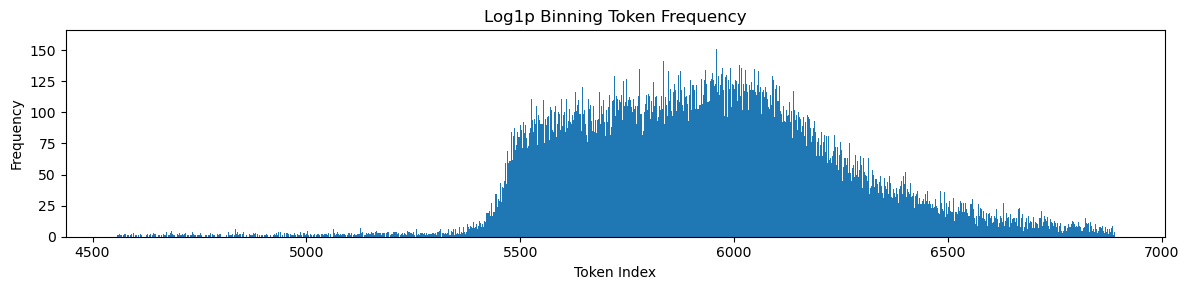

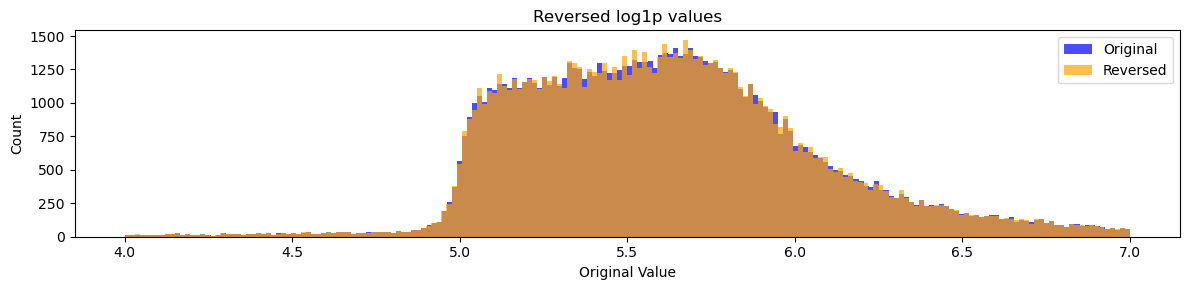

In [18]:
def log1p_tokenizer(values, num_bins=350, token_min=0):
    log_vals = np.log1p(values)
    log_min, log_max = np.log1p(1), np.log1p(9)
    bins = np.linspace(log_min, log_max, num_bins + 1)
    bin_indices = np.digitize(log_vals, bins[1:-1], right=True)
    tokens = token_min + bin_indices
    return tokens, bins

def log1p_detokenize(tokens, bin_edges, token_min=0):
    indices = tokens - token_min
    # Clip for safety
    indices = np.clip(indices, 0, len(bin_edges) - 2)
    # Reconstruct log1p value using bin center
    log_vals = 0.5 * (bin_edges[indices] + bin_edges[indices + 1])
    # Invert log1p
    return np.expm1(log_vals)

log_tokens, log_bins = log1p_tokenizer(shifted_eta, num_bins=8000)
reversed_log_values = log1p_detokenize(log_tokens, log_bins)

plot_token_freq(log_tokens, "Log1p Binning Token Frequency")

plt.figure(figsize=(12, 3))
plt.hist(shifted_eta, bins=200, color='blue', alpha=0.7)
plt.hist(reversed_log_values, bins=200, color='orange', alpha=0.7)
plt.title("Reversed log1p values")
plt.xlabel("Original Value")
plt.ylabel("Count")
plt.legend(['Original', 'Reversed'])
plt.tight_layout()
plt.show()

This is with a custom density aware binning.

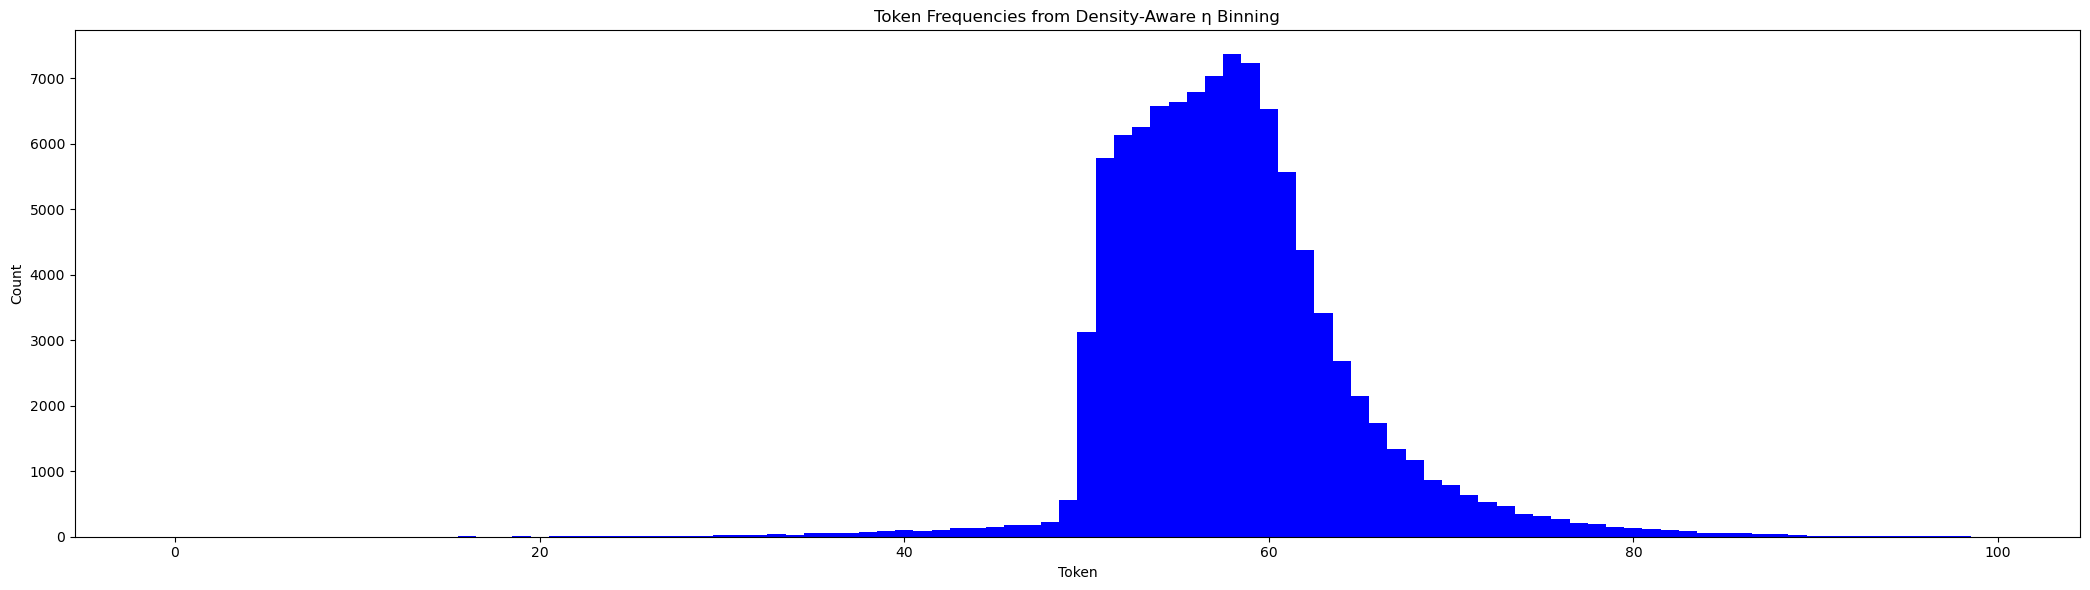

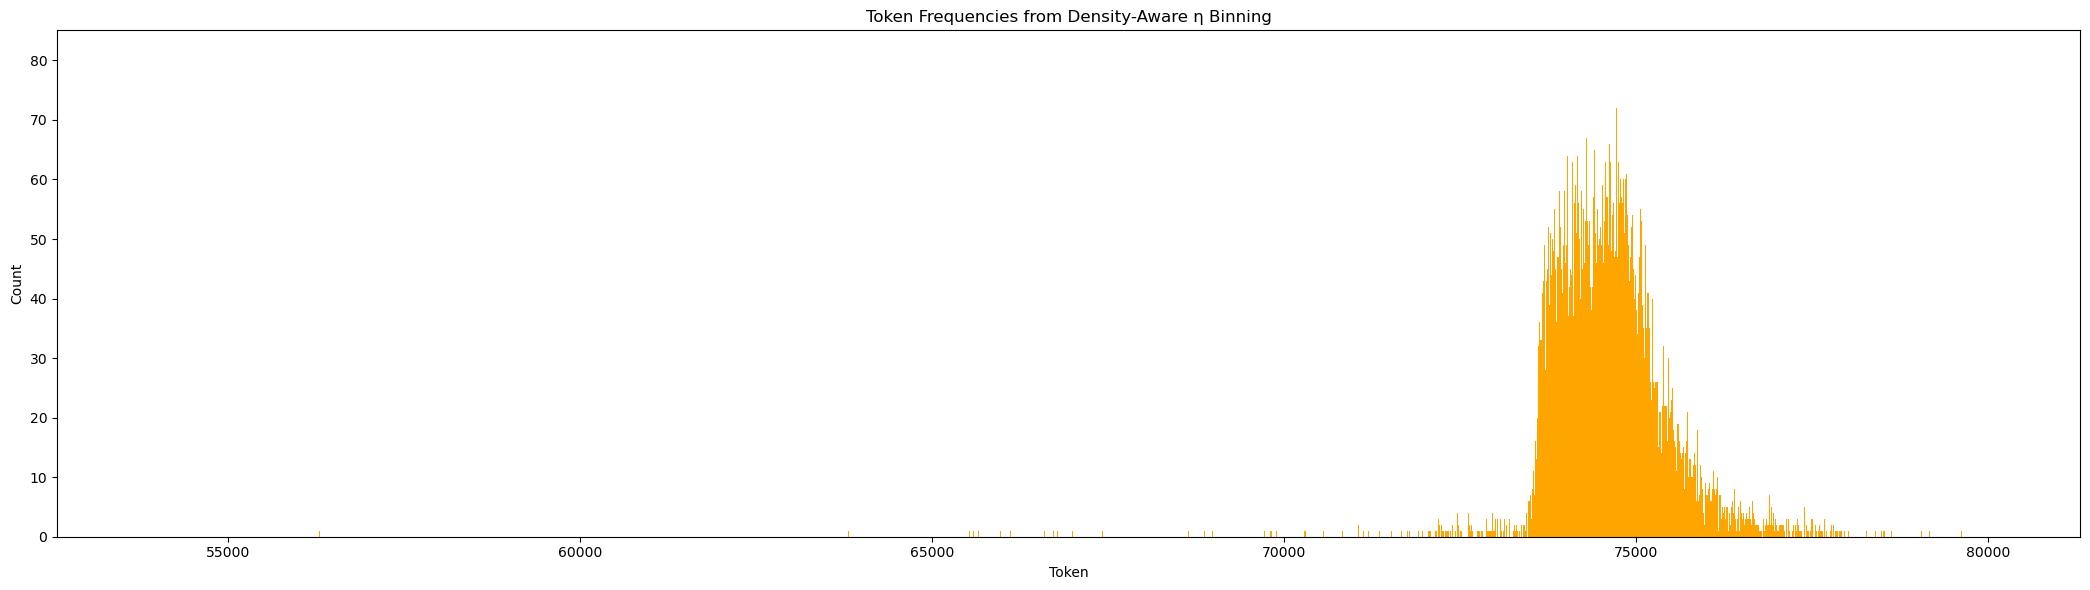

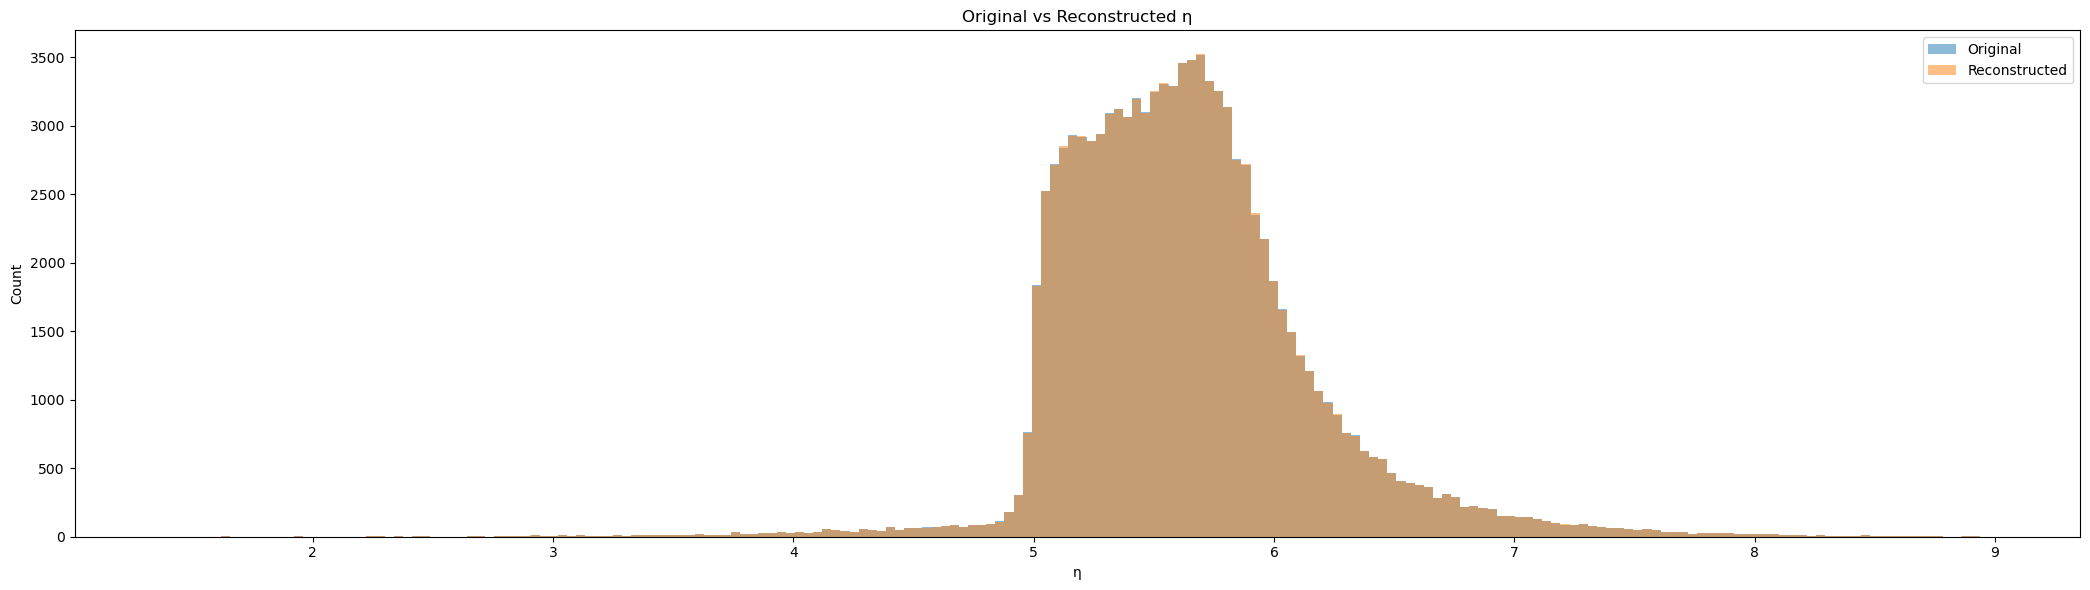

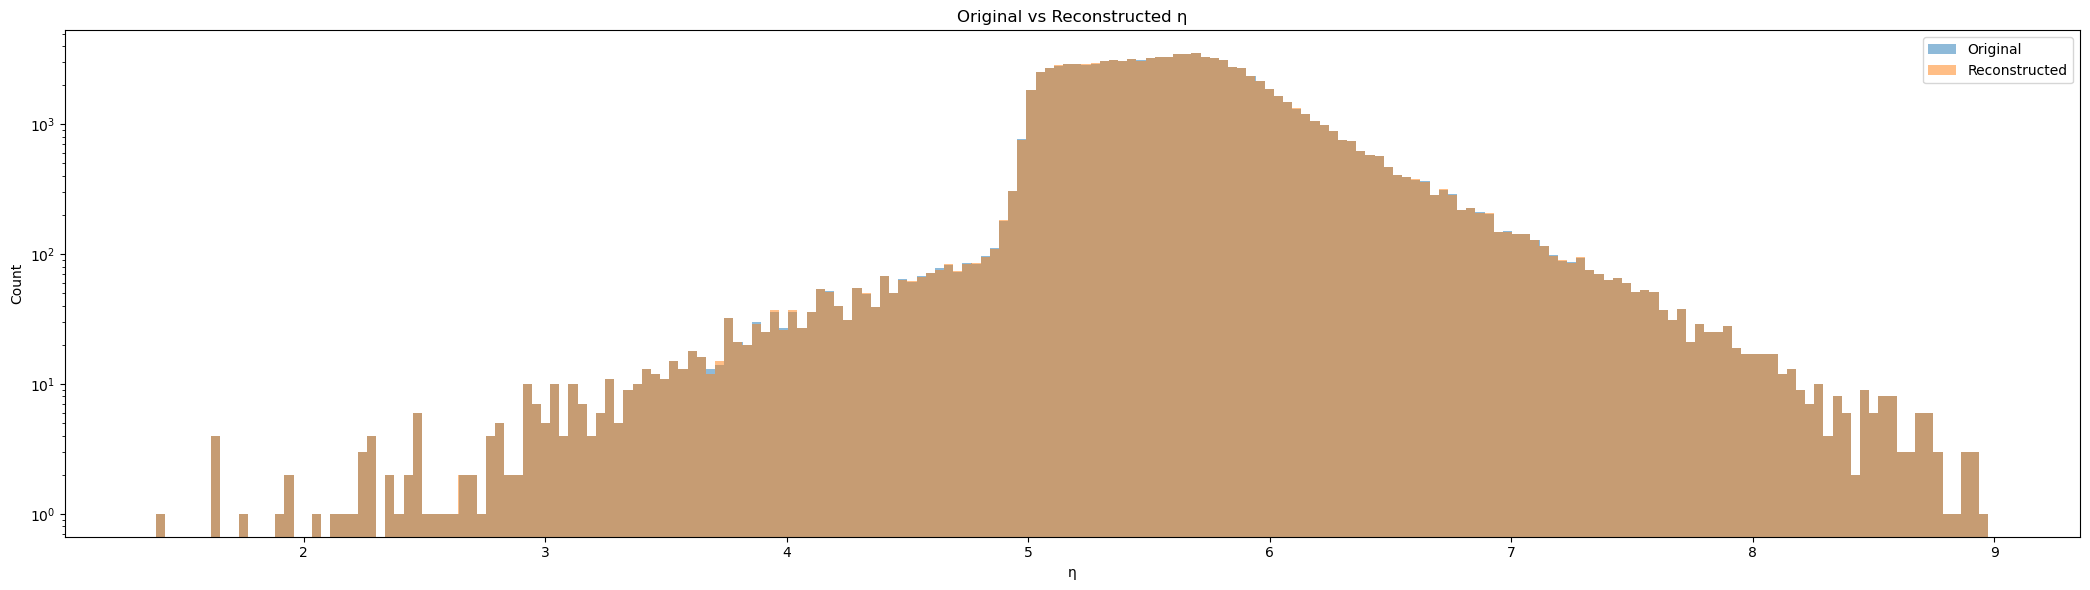

In [13]:
def density_aware_eta_tokenizer(eta, num_bins=8000, token_min=0):
    # Step 1: Choose breakpoints manually (or via percentile zones)
    center = eta[np.abs(eta) < 2]
    mid = eta[(np.abs(eta) >= 2) & (np.abs(eta) < 4)]
    tails = eta[np.abs(eta) >= 4]

    # Allocate bins by region
    num_bins_center = int(0.5 * num_bins)
    num_bins_mid = int(0.3 * num_bins)
    num_bins_tail = num_bins - num_bins_center - num_bins_mid

    # Define bin edges for each region
    center_edges = np.linspace(-2, 2, num_bins_center + 1)
    mid_edges = np.concatenate([
        np.linspace(-4, -2, num_bins_mid // 2, endpoint=False),
        np.linspace(2, 4, num_bins_mid // 2 + 1)
    ])
    tail_edges = np.concatenate([
        np.linspace(eta.min(), -4, num_bins_tail // 2, endpoint=False),
        np.linspace(4, eta.max(), num_bins_tail // 2 + 1)
    ])

    # Merge all bin edges
    bin_edges = np.sort(np.unique(np.concatenate([tail_edges, mid_edges, center_edges])))

    # Digitize
    token_indices = np.digitize(eta, bin_edges[1:-1], right=True)
    tokens = token_min + token_indices

    return tokens, bin_edges

def density_aware_eta_detokenize(tokens, bin_edges, token_min=0):
    indices = np.clip(tokens - token_min, 0, len(bin_edges) - 2)
    return 0.5 * (bin_edges[indices] + bin_edges[indices + 1])

tokens, bin_edges = density_aware_eta_tokenizer(shifted_eta, num_bins=80000)
eta_reconstructed = density_aware_eta_detokenize(tokens, bin_edges)

plt.figure()
plt.bar(dict(tokenized_shifted_eta_freq).keys(), dict(tokenized_shifted_eta_freq).values(), width=1.0, color='blue')
plt.title("Token Frequencies from Density-Aware η Binning")
plt.xlabel("Token")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Plot token frequencies
density_aware_counts = Counter(tokens)
plt.figure()
plt.bar(density_aware_counts.keys(), density_aware_counts.values(), width=1.0, color='orange')
plt.title("Token Frequencies from Density-Aware η Binning")
plt.xlabel("Token")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Compare η distributions
plt.figure()
plt.hist(shifted_eta, bins=200, alpha=0.5, label='Original')
plt.hist(eta_reconstructed, bins=200, alpha=0.5, label='Reconstructed')
plt.legend()
plt.title("Original vs Reconstructed η")
plt.xlabel("η")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Compare η distributions
plt.figure()
plt.yscale('log')
plt.hist(shifted_eta, bins=200, alpha=0.5, label='Original')
plt.hist(eta_reconstructed, bins=200, alpha=0.5, label='Reconstructed')
plt.legend()
plt.title("Original vs Reconstructed η")
plt.xlabel("η")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Adaptive binning with mean-based decoding.

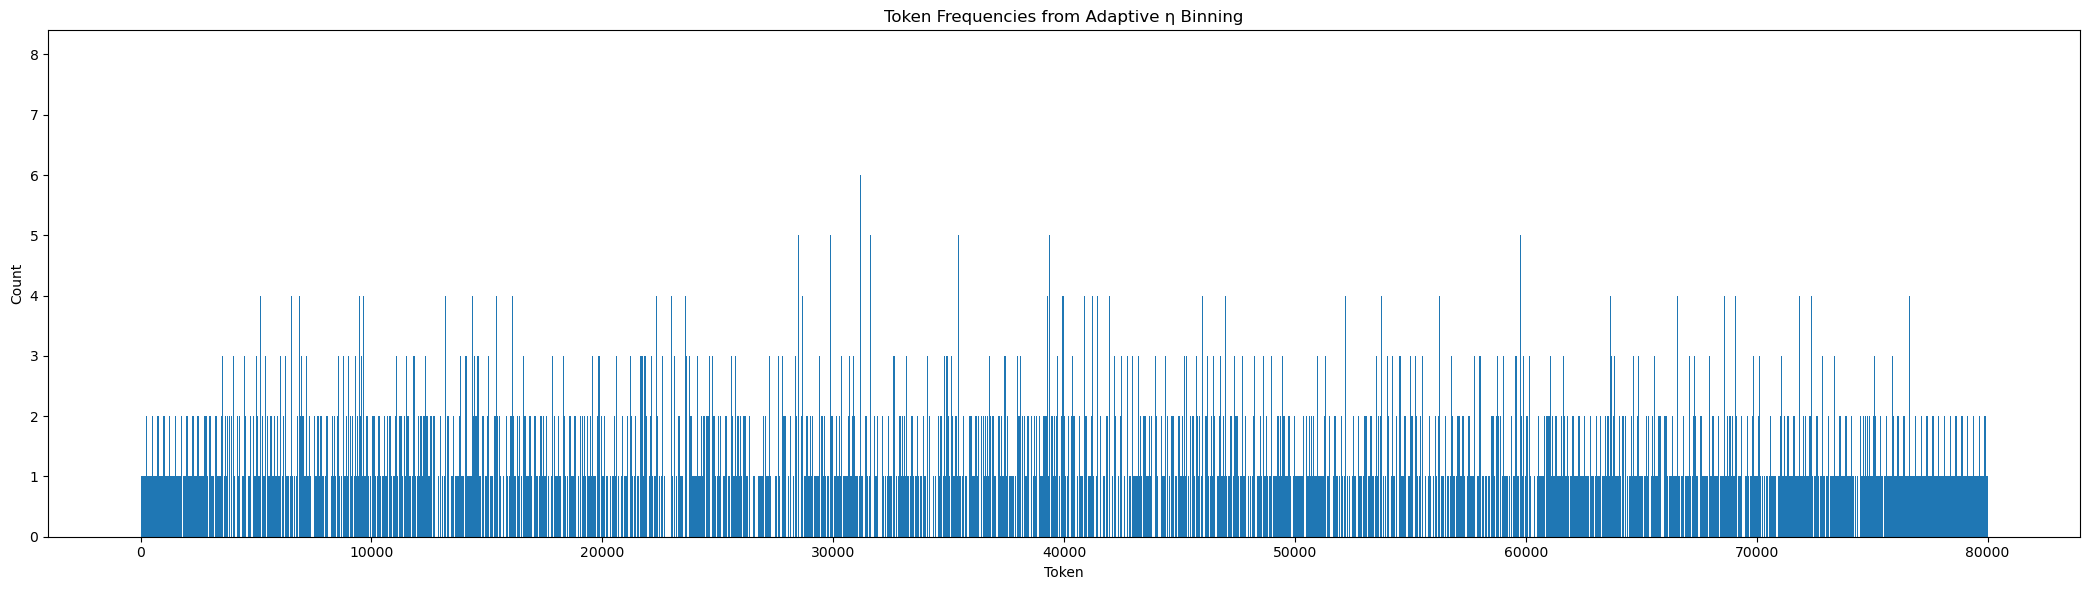

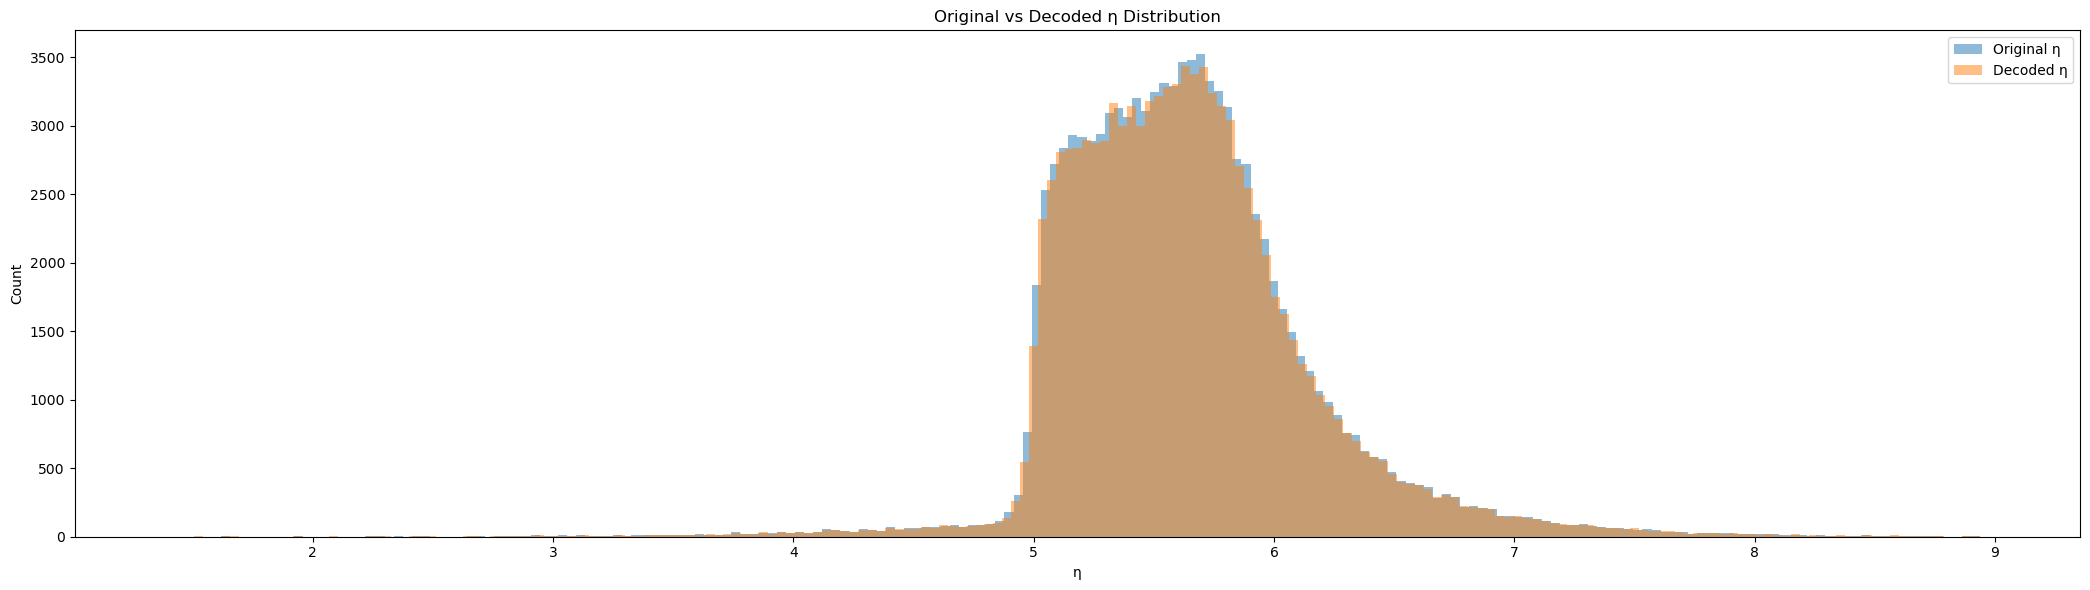

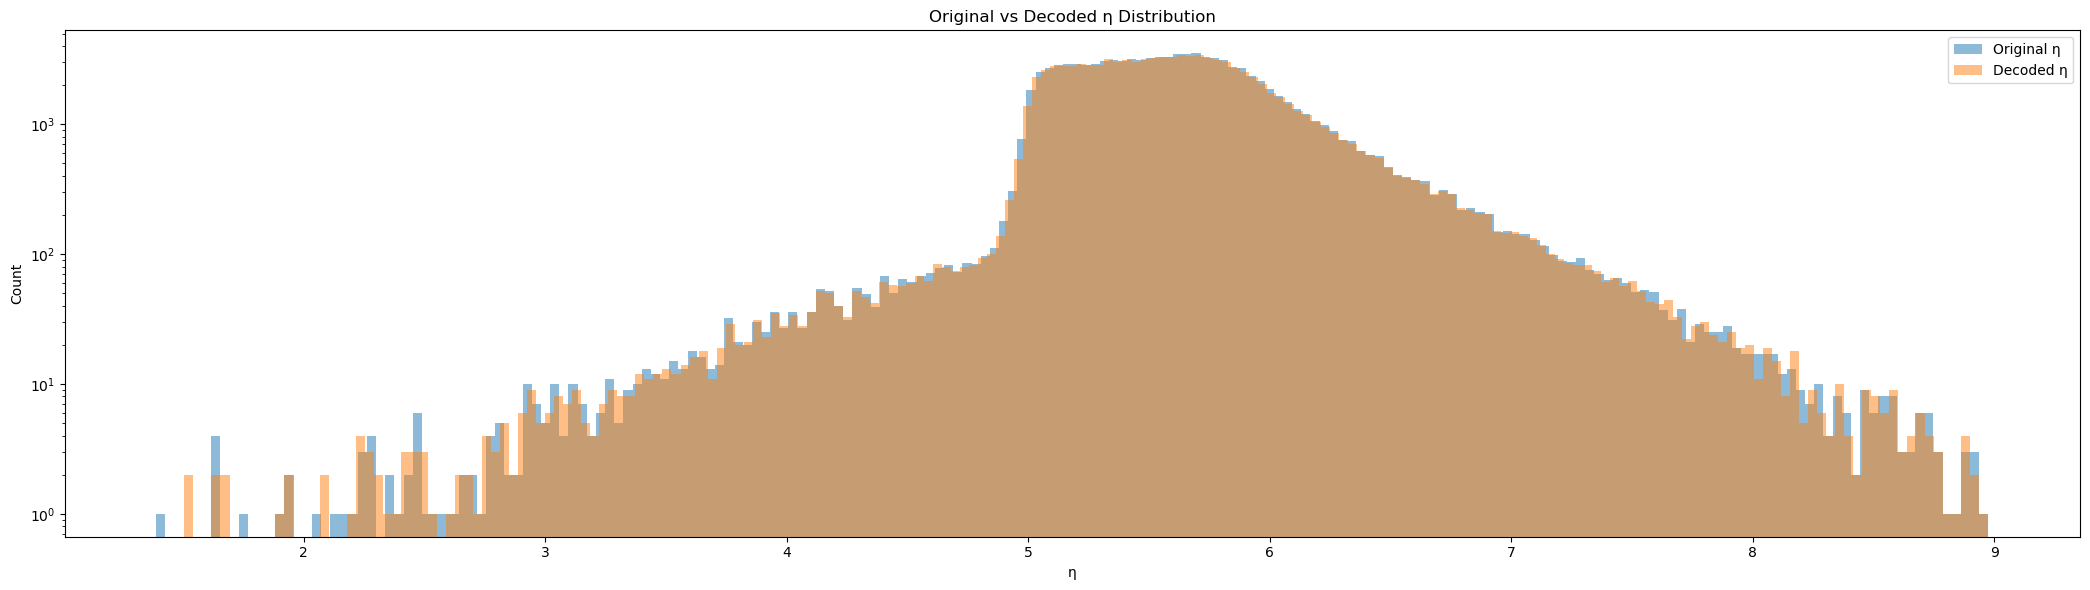

In [15]:
def adaptive_eta_tokenizer(eta, num_bins=8000, token_min=0):
    eta = np.sort(eta)
    bin_edges = np.interp(
        np.linspace(0, len(eta), num_bins + 1),
        np.arange(len(eta)),
        eta
    )

    bin_indices = np.digitize(eta, bin_edges[1:-1], right=True)
    tokens = token_min + bin_indices

    # Store means per bin for decoding
    bin_means = np.zeros(num_bins)
    for i in range(num_bins):
        in_bin = eta[bin_indices == i]
        if len(in_bin) > 0:
            bin_means[i] = in_bin.mean()
        else:
            bin_means[i] = 0.5 * (bin_edges[i] + bin_edges[i + 1])

    return tokens, bin_edges, bin_means

def adaptive_eta_detokenize(tokens, bin_means, token_min=0):
    indices = np.clip(tokens - token_min, 0, len(bin_means) - 1)
    return bin_means[indices]

tokens, bin_edges, bin_means = adaptive_eta_tokenizer(shifted_eta, num_bins=80000)
decoded_eta = adaptive_eta_detokenize(tokens, bin_means)

# Plot token frequencies
token_counts = Counter(tokens)
token_keys = sorted(token_counts.keys())
token_values = [token_counts[k] for k in token_keys]

plt.figure()
plt.bar(token_keys, token_values, width=1.0)
plt.title("Token Frequencies from Adaptive η Binning")
plt.xlabel("Token")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Plot original vs reconstructed η
plt.figure()
plt.hist(shifted_eta, bins=200, alpha=0.5, label='Original η')
plt.hist(decoded_eta, bins=200, alpha=0.5, label='Decoded η')
plt.legend()
plt.title("Original vs Decoded η Distribution")
plt.xlabel("η")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Plot original vs reconstructed η
plt.figure()
plt.yscale('log')
plt.hist(shifted_eta, bins=200, alpha=0.5, label='Original η')
plt.hist(decoded_eta, bins=200, alpha=0.5, label='Decoded η')
plt.legend()
plt.title("Original vs Decoded η Distribution")
plt.xlabel("η")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

This is with log binning. Using geomspace and a custom inverse geomspace.

[(0, 0), (1, 3), (2, 5), (3, 7), (4, 11), (5, 12), (6, 19), (7, 12), (8, 13), (9, 19), (10, 33), (11, 36), (12, 43), (13, 60), (14, 67), (15, 73), (16, 102), (17, 135), (18, 147), (19, 185), (20, 205), (21, 250), (22, 330), (23, 348), (24, 483), (25, 556), (26, 716), (27, 870), (28, 976), (29, 1364), (30, 1660), (31, 2103), (32, 2683), (33, 3497), (34, 4624), (35, 6045), (36, 7251), (37, 8057), (38, 8167), (39, 7779), (40, 7434), (41, 7437), (42, 6946), (43, 6865), (44, 6537), (45, 3465), (46, 534), (47, 224), (48, 192), (49, 189), (50, 150), (51, 142), (52, 119), (53, 107), (54, 109), (55, 91), (56, 75), (57, 76), (58, 51), (59, 53), (60, 35), (61, 32), (62, 31), (63, 25), (64, 19), (65, 11), (66, 19), (67, 17), (68, 16), (69, 9), (70, 6), (71, 4), (72, 2), (73, 7), (74, 3), (75, 6), (76, 5), (77, 1), (78, 1), (79, 2), (80, 1), (81, 1), (82, 3), (83, 1), (84, 0), (85, 1), (86, 0), (87, 0), (88, 0), (89, 0), (90, 0), (91, 0), (92, 0), (93, 0), (94, 0), (95, 0), (96, 0), (97, 0), (98, 0

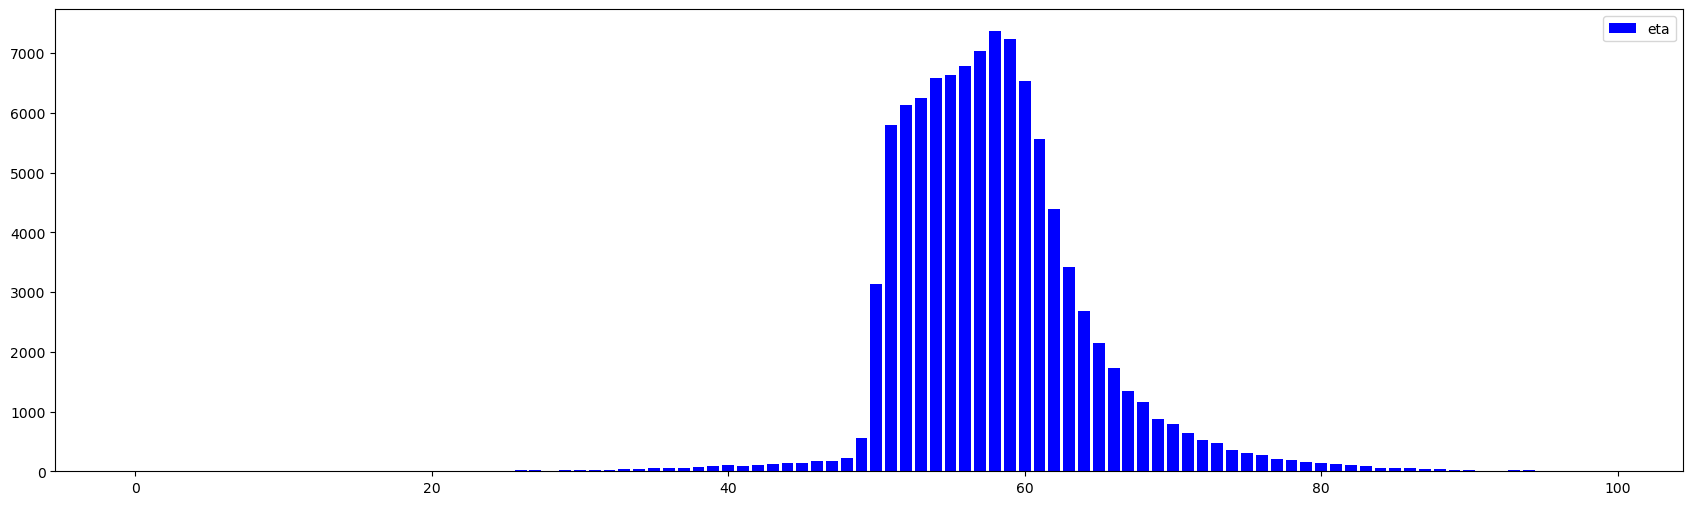

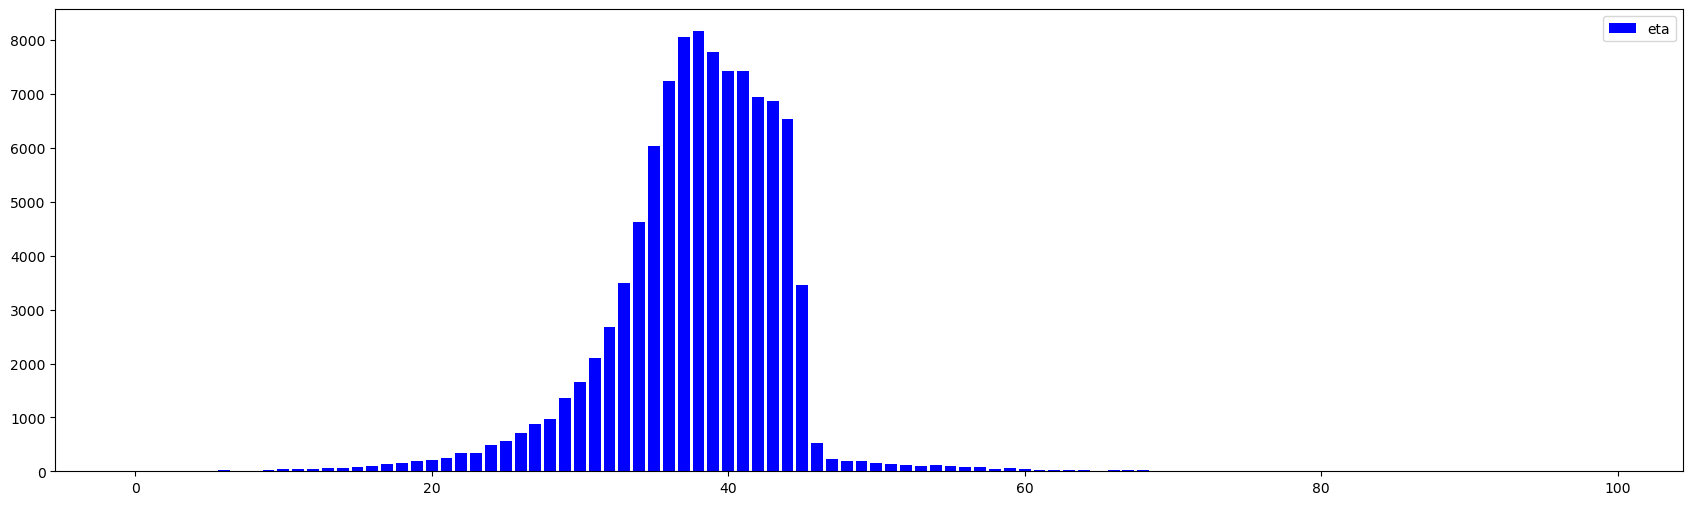

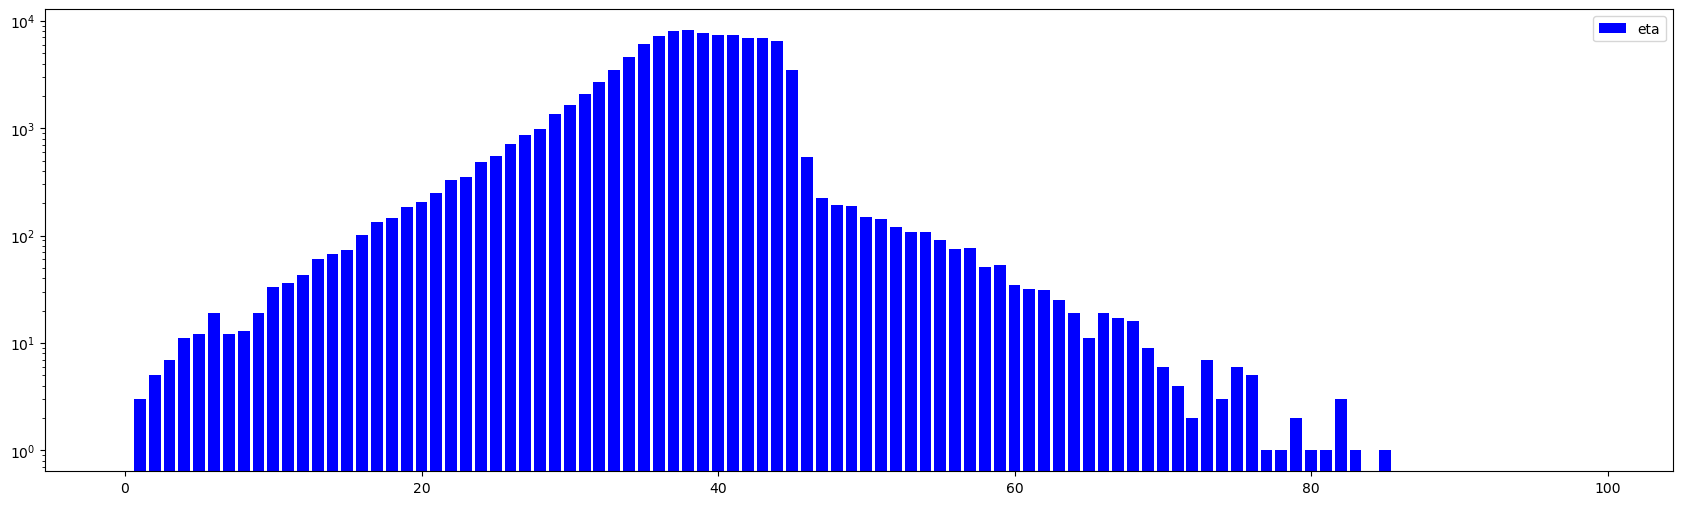

In [16]:
def inverse_geomspace(start, stop, num, power=1):
    """
    Generate values from start to stop with spacing compressed toward the end,
    controlled by a power parameter.

    Parameters:
        start (float): The start of the sequence.
        stop (float): The end of the sequence.
        num (int): Number of values to generate.
        power (float): Compression strength (>1 = stronger compression).

    Returns:
        numpy.ndarray: Array of values with inverse geometric spacing.
    """
    x = np.linspace(0, 1, num)
    scaled = (1 - x**power)  # flip and scale with power
    return start + (stop - start) * scaled

log_shifted_eta_bins = inverse_geomspace(0.1, 9, 100)
log_binned_tokenized_shifted_eta = np.digitize(shifted_eta, bins=log_shifted_eta_bins)
log_binned_tokenized_shifted_eta_freq = Counter(log_binned_tokenized_shifted_eta)
full_tokenized_freq = {i: 0 for i in range(0, 100)}
full_tokenized_freq.update(log_binned_tokenized_shifted_eta_freq)
log_binned_tokenized_shifted_eta_freq = sorted(full_tokenized_freq.items(), key=lambda x: x[0])

print(log_binned_tokenized_shifted_eta_freq)
print(dict(log_binned_tokenized_shifted_eta_freq))

plt.bar(np.arange(0, 100, 1), dict(tokenized_shifted_eta_freq).values(), label=f'eta', color=anal.plotting.colors[0])
plt.legend()
plt.show()

plt.bar(np.arange(0, 100, 1), dict(log_binned_tokenized_shifted_eta_freq).values(), label=f'eta', color=anal.plotting.colors[0])
plt.legend()
plt.show()

plt.yscale("log")
plt.bar(np.arange(0, 100, 1), dict(log_binned_tokenized_shifted_eta_freq).values(), label=f'eta', color=anal.plotting.colors[0])
plt.legend()
plt.show()

This is with gaussian binning, most resolution in the center and then coarser as it moves away.

In [18]:
from scipy.stats import norm
from scipy.interpolate import interp1d

# Basic median centered gaussian spacing
def simple_gaussian_space(start, stop, num, scale=1.0):
    """
    Create a grid that is densest at the center and more sparse at the ends,
    mimicking a Gaussian profile.

    Parameters:
        start (float): Lower bound of output range.
        stop (float): Upper bound of output range.
        num (int): Number of bins or points.
        scale (float): Controls sharpness; higher = sharper peak at center.

    Returns:
        numpy.ndarray: Array with center-dense, tail-sparse spacing.
    """
    # linspace from 0 to 1, but exclude exact 0 and 1 to avoid ±inf
    probs = np.linspace(1e-6, 1 - 1e-6, num)
    # Use inverse Gaussian CDF (symmetric bell shape)
    z = norm.ppf(probs)  # in [-inf, inf], centered at 0
    z = z / np.max(np.abs(z))  # normalize to [-1, 1]
    z = 0.5 + 0.5 * z / scale  # shrink to [0, 1] range
    return start + (stop - start) * np.clip(z, 0, 1)
    
# More advanced Gaussian spacing with peak control
def gaussian_space(start, stop, num, center, sigma=1.0):
    """
    Generate a Gaussian-spaced array of points between start and stop,
    with the highest density of points near `center`.

    Parameters:
        start (float): Start of range.
        stop (float): End of range.
        num (int): Number of points to generate.
        center (float): Location where spacing is most dense.
        sigma (float): Controls sharpness of peak (standard deviation of Gaussian).

    Returns:
        np.ndarray: Array of values spaced according to a Gaussian profile.
    """
    # Create a fine-grained range to define the target density
    x_fine = np.linspace(start, stop, 10_000)
    pdf = norm.pdf(x_fine, loc=center, scale=sigma)
    cdf = np.cumsum(pdf)
    cdf = (cdf - cdf.min()) / (cdf.max() - cdf.min())  # normalize to [0, 1]

    # Invert CDF: get target values from uniform
    inv_cdf = interp1d(cdf, x_fine, bounds_error=False, fill_value=(start, stop))
    uniform_probs = np.linspace(0, 1, num)
    return inv_cdf(uniform_probs)

# Detokenization of gaussian bins using bin medians
def detokenize_gaussian_bins(tokens, bin_edges):
    """
    Decode tokenized values back to approximate original values
    using bin centers.

    Parameters:
        tokens (np.ndarray): Array of token indices (0-based).
        bin_edges (np.ndarray): Bin edges used during digitization.

    Returns:
        np.ndarray: Decoded values.
    """
    # Bin centers: len = len(bin_edges) + 1 - 1 = len(bin_edges)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    # Clip tokens to valid range
    tokens = np.clip(tokens, 0, len(bin_centers) - 1)
    return bin_centers[tokens]

# Helper for detokenization of gaussian bins using bin means
def build_bin_means(values, bin_edges):
    bin_indices = np.digitize(values, bin_edges[1:-1], right=True)  # tokens range from 0 to len(bin_edges) - 2
    num_bins = len(bin_edges) - 1  # Number of actual bins
    bin_means = np.zeros(num_bins)
    for i in range(num_bins):
        in_bin = values[bin_indices == i]
        if len(in_bin) > 0:
            bin_means[i] = in_bin.mean()
        else:
            bin_means[i] = 0.5 * (bin_edges[i] + bin_edges[i + 1])
    return bin_means

# Linear tokenized eta with 8000 bins for visual comparisons
granular_shifted_eta_bins = np.linspace(1, 9, 8000)
tokenized_granular_shifted_eta = np.digitize(shifted_eta, bins=granular_shifted_eta_bins)
tokenized_granular_shifted_eta_freq = Counter(tokenized_granular_shifted_eta)
full_tokenized_freq = {i: 0 for i in range(0, 100)}
full_tokenized_freq.update(tokenized_granular_shifted_eta_freq)
tokenized_granular_shifted_eta_freq = sorted(full_tokenized_freq.items(), key=lambda x: x[0])

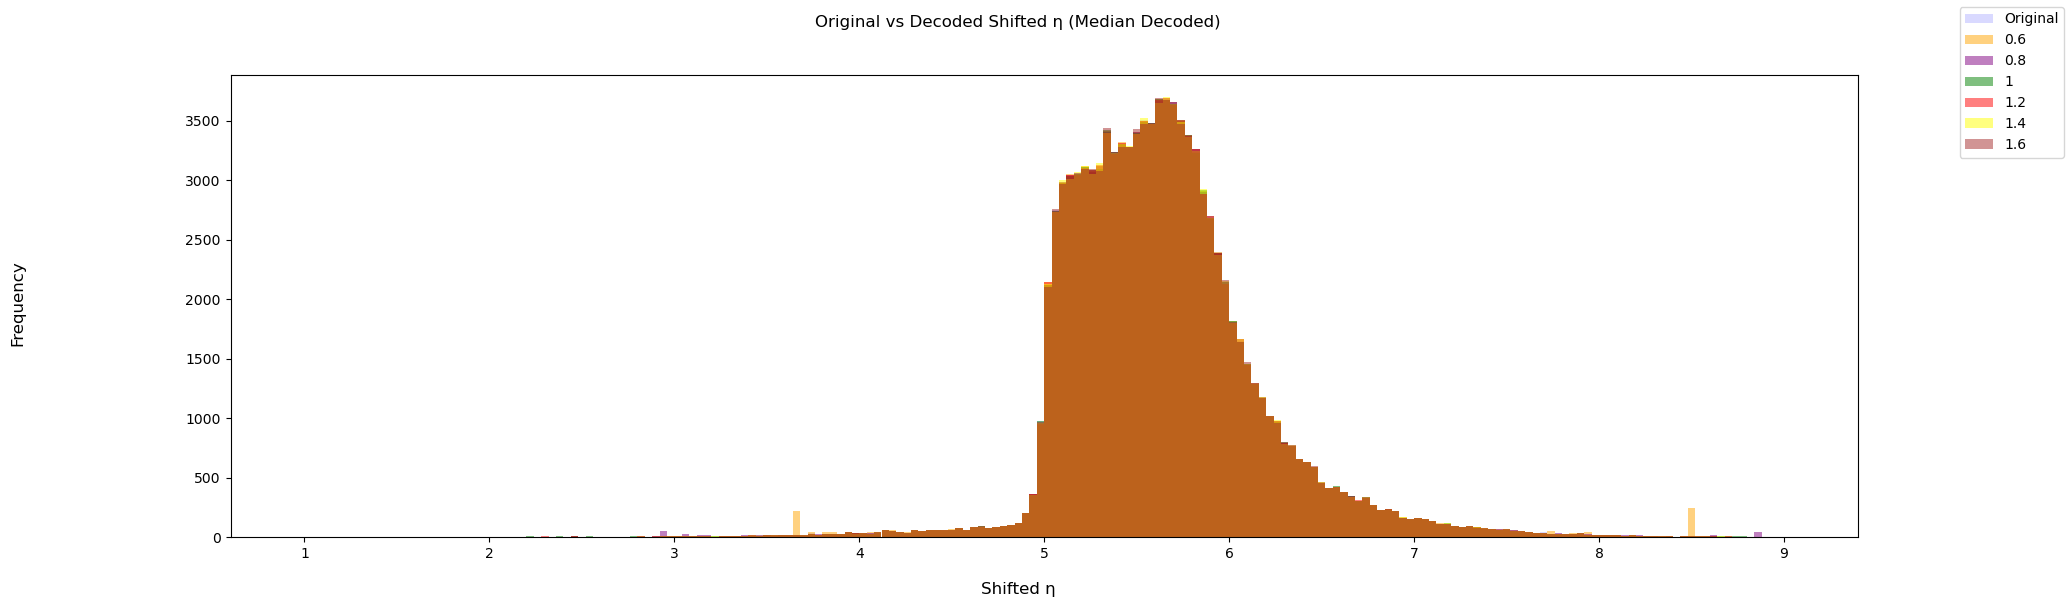

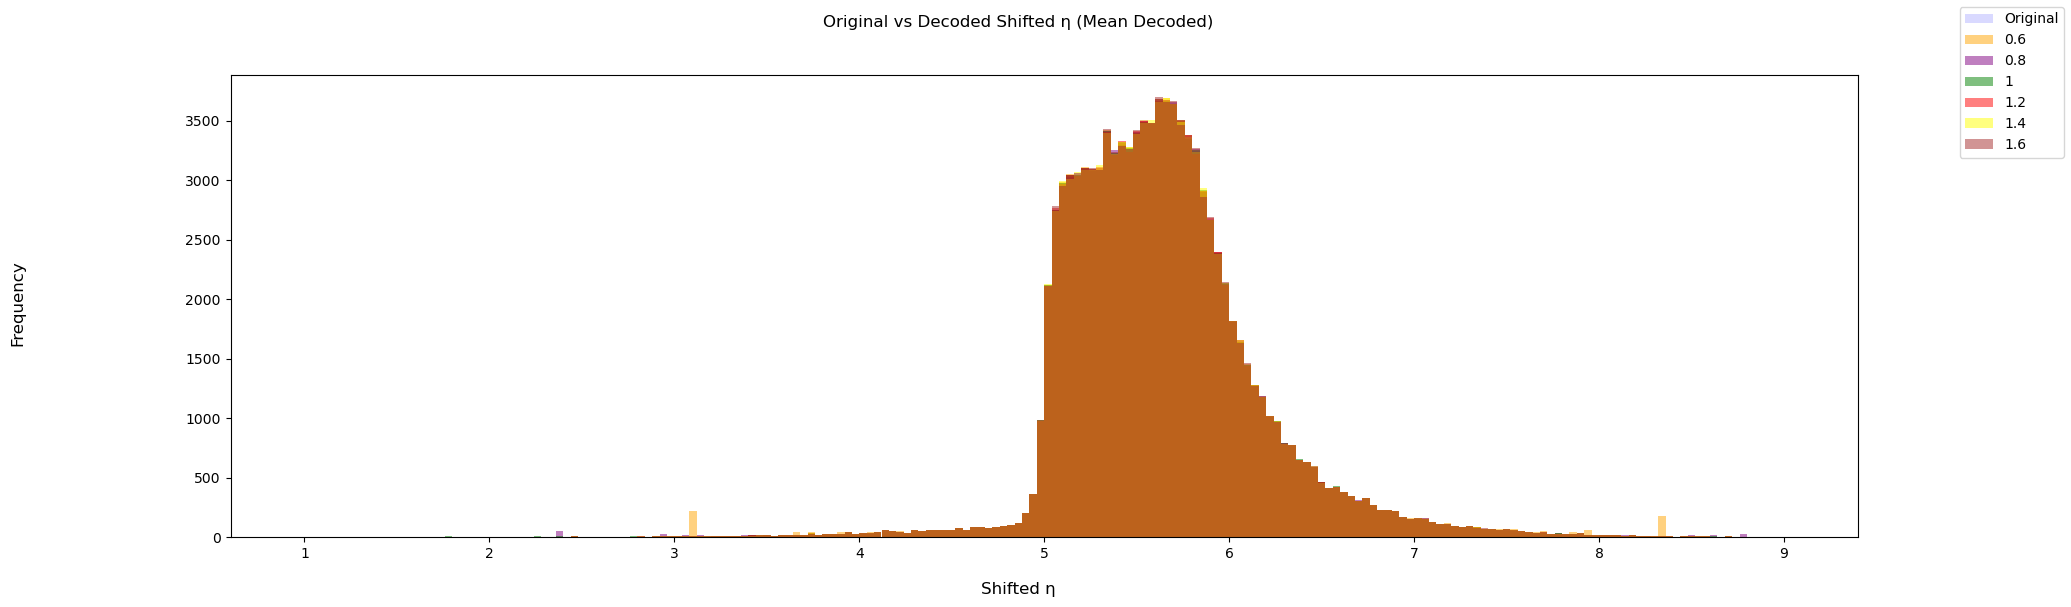

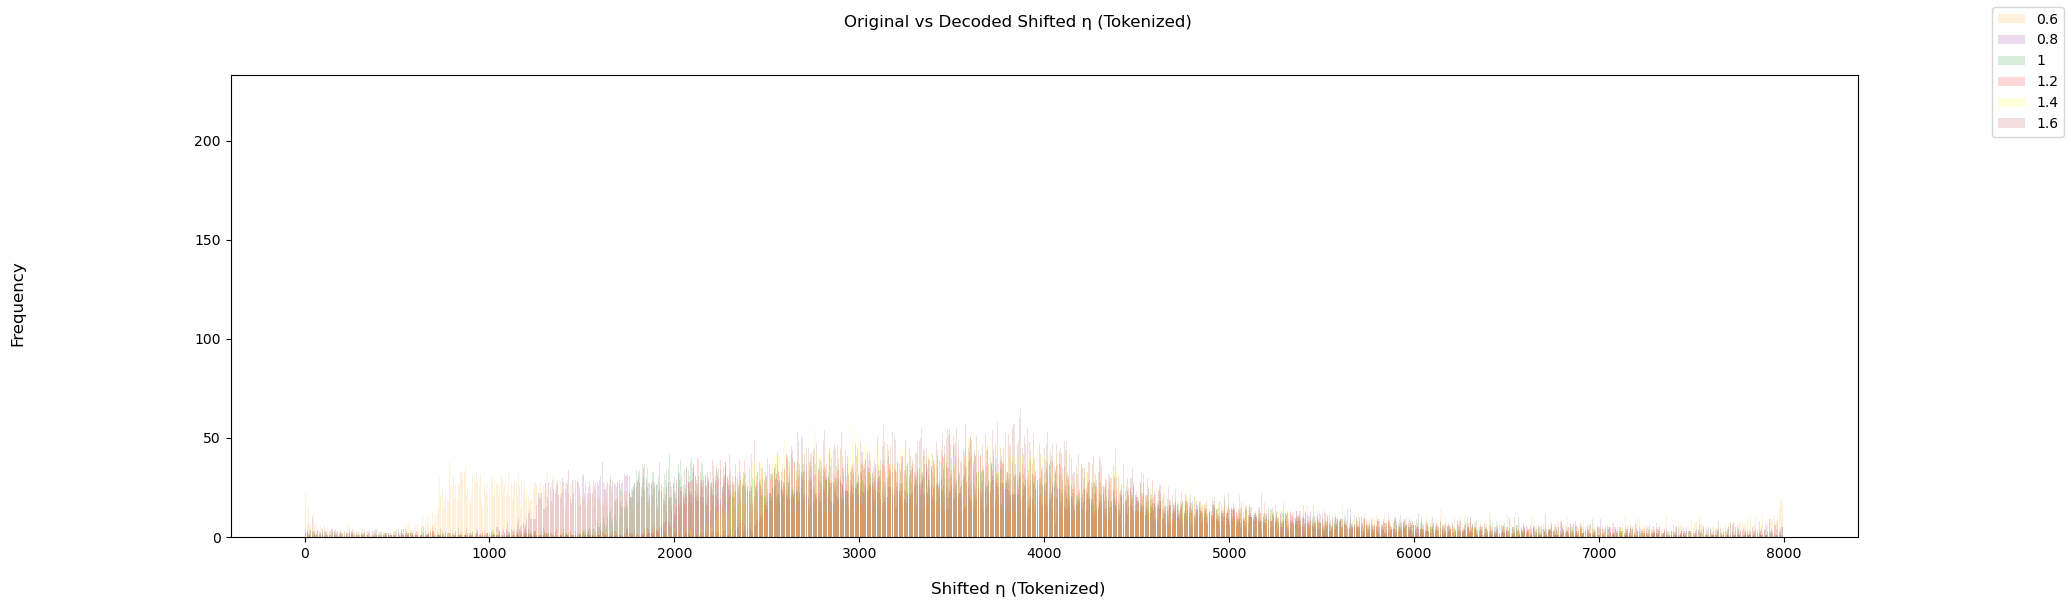

In [ ]:
med_val_fig, med_val_ax = plt.subplots()
med_val_fig.suptitle("Original vs Decoded Shifted η (Median Decoded)")
med_val_fig.supxlabel("Shifted η")
med_val_fig.supylabel("Frequency")
med_val_ax.hist(shifted_eta, range=(1, 9), bins=200, label="Original", color=anal.plotting.colors[0], alpha=0.15)

mean_val_fig, mean_val_ax = plt.subplots()
mean_val_fig.suptitle("Original vs Decoded Shifted η (Mean Decoded)")
mean_val_fig.supxlabel("Shifted η")
mean_val_fig.supylabel("Frequency")
mean_val_ax.hist(shifted_eta, range=(1, 9), bins=200, label="Original", color=anal.plotting.colors[0], alpha=0.15)

tok_fig, tok_ax = plt.subplots()
tok_fig.suptitle("Original vs Decoded Shifted η (Tokenized)")
tok_fig.supxlabel("Shifted η (Tokenized)")
tok_fig.supylabel("Frequency")
# tok_ax.bar(dict(tokenized_shifted_eta_freq).keys(), dict(tokenized_shifted_eta_freq).values(), label="Original", color=anal.plotting.colors[0], alpha=0.5)

for idx, sig in enumerate([0.6, 0.8, 1, 1.2, 1.4, 1.6]):
    n_gaussian_shifted_eta_bins = 8000
    gaussian_shifted_eta_bins = gaussian_space(1, 9, n_gaussian_shifted_eta_bins, 5.8, sigma=sig)
    gaussian_bin_tokenized_shifted_eta = np.digitize(shifted_eta, bins=gaussian_shifted_eta_bins)
    gaussian_bin_tokenized_shifted_eta_freq = Counter(gaussian_bin_tokenized_shifted_eta)
    full_tokenized_freq = {i: 0 for i in range(0, n_gaussian_shifted_eta_bins)}
    full_tokenized_freq.update(gaussian_bin_tokenized_shifted_eta_freq)
    gaussian_bin_tokenized_shifted_eta_freq = sorted(full_tokenized_freq.items(), key=lambda x: x[0])\
    
    # Bin meadian
    median_decoded_eta = detokenize_gaussian_bins(gaussian_bin_tokenized_shifted_eta, gaussian_shifted_eta_bins)

    # Bin mean
    bin_means = build_bin_means(shifted_eta, gaussian_shifted_eta_bins)
    _tokens = np.digitize(shifted_eta, gaussian_shifted_eta_bins[1:-1], right=True)
    _tokens = np.clip(_tokens, 0, len(bin_means) - 1)
    mean_decoded_eta = bin_means[_tokens]
    
    med_val_ax.hist(median_decoded_eta, range=(1, 9), bins=200, label=f'{sig}', color=anal.plotting.colors[idx + 1], alpha=0.5)
    mean_val_ax.hist(mean_decoded_eta, range=(1, 9), bins=200, label=f'{sig}', color=anal.plotting.colors[idx + 1], alpha=0.5)
    tok_ax.bar(dict(gaussian_bin_tokenized_shifted_eta_freq).keys(), dict(gaussian_bin_tokenized_shifted_eta_freq).values(), label=f'{sig}', color=anal.plotting.colors[idx + 1], alpha=0.15)
    
med_val_fig.legend()
med_val_fig.show()
mean_val_fig.legend()
mean_val_fig.show()
tok_fig.legend()
tok_fig.show()

Looking at the above, 0.6 seems the most promising. There is a clearer picture of that.

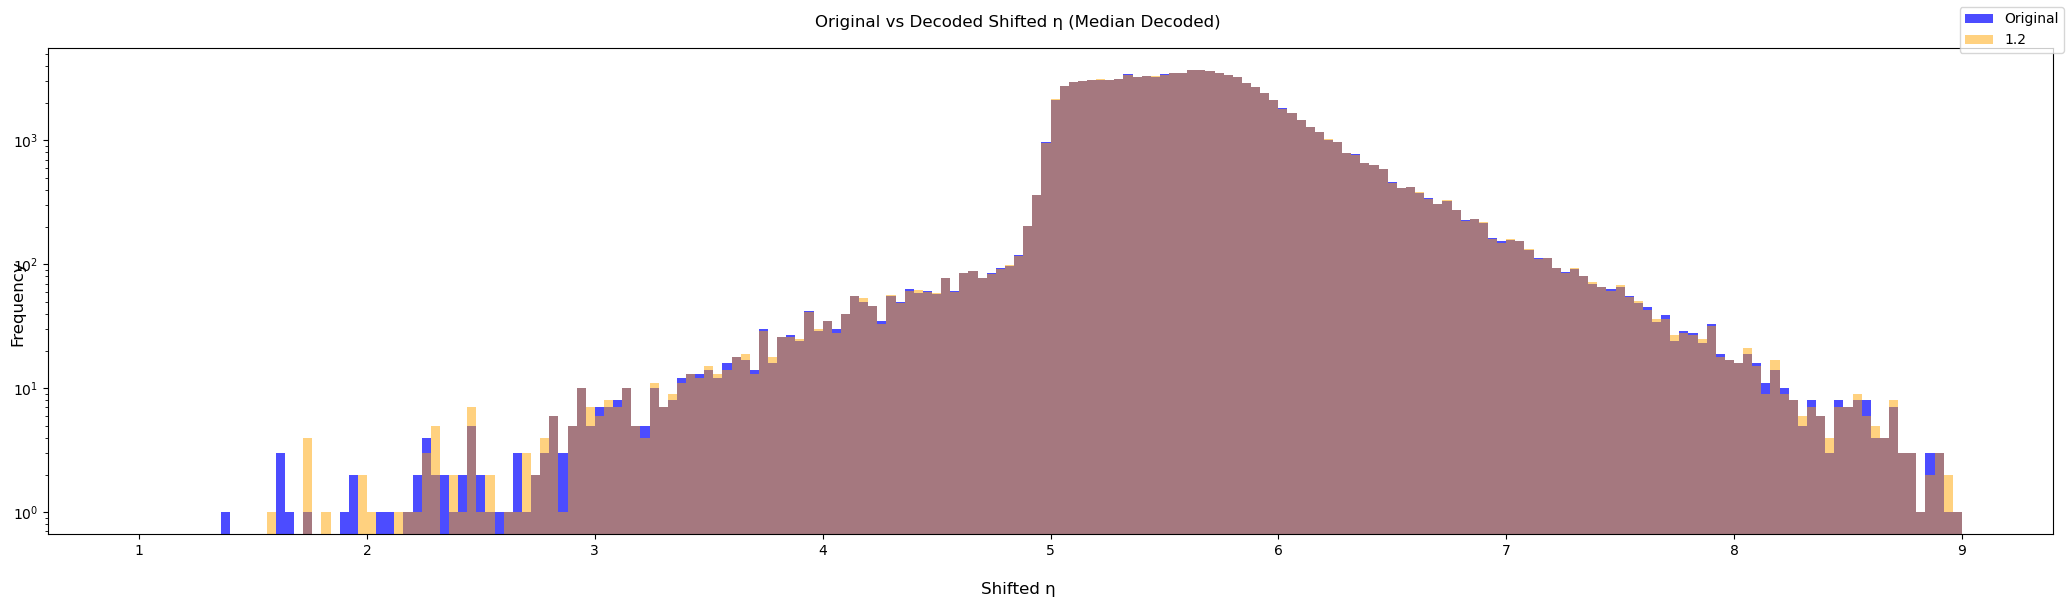

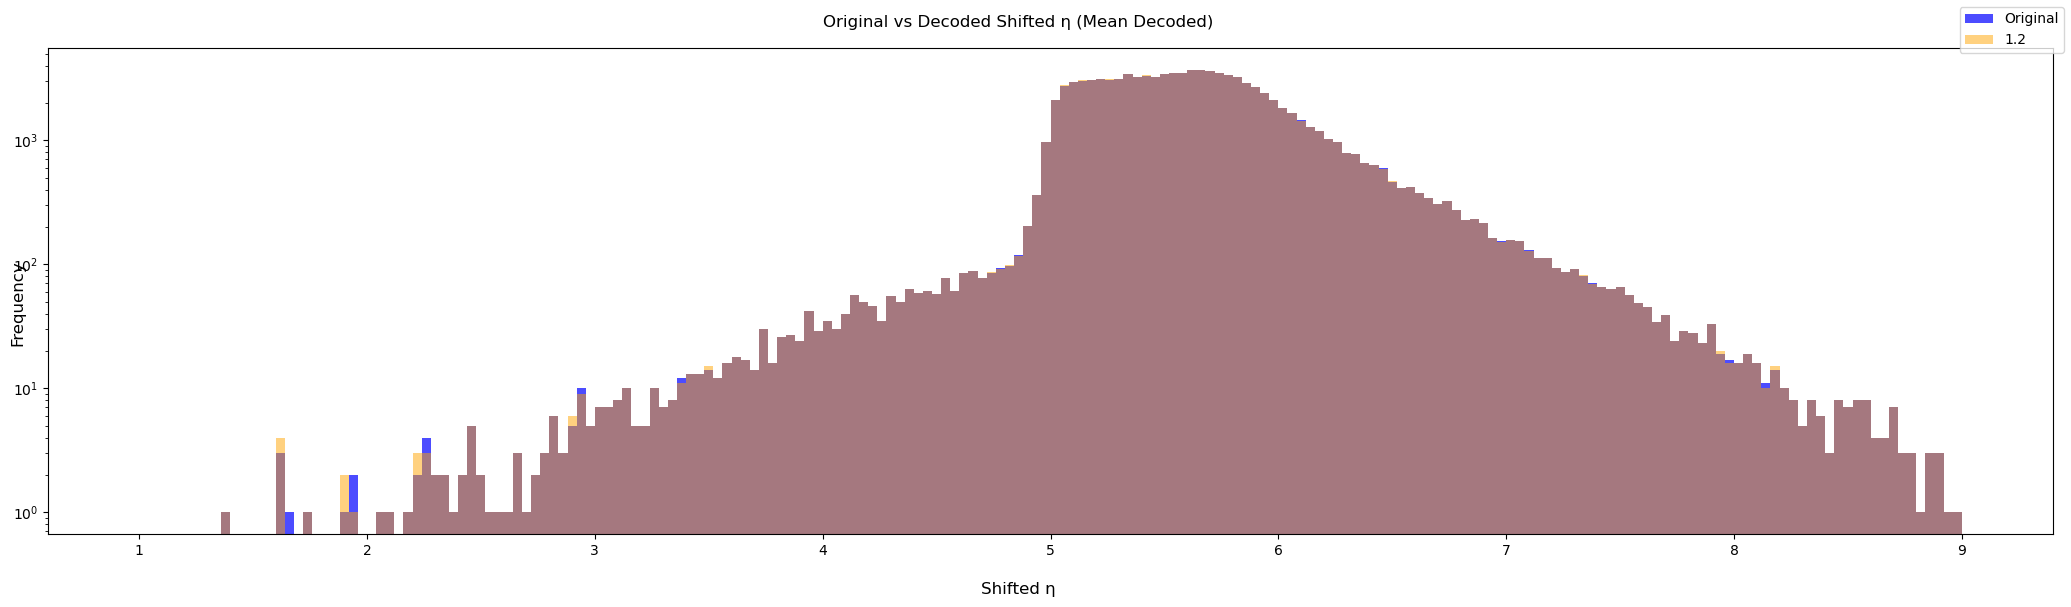

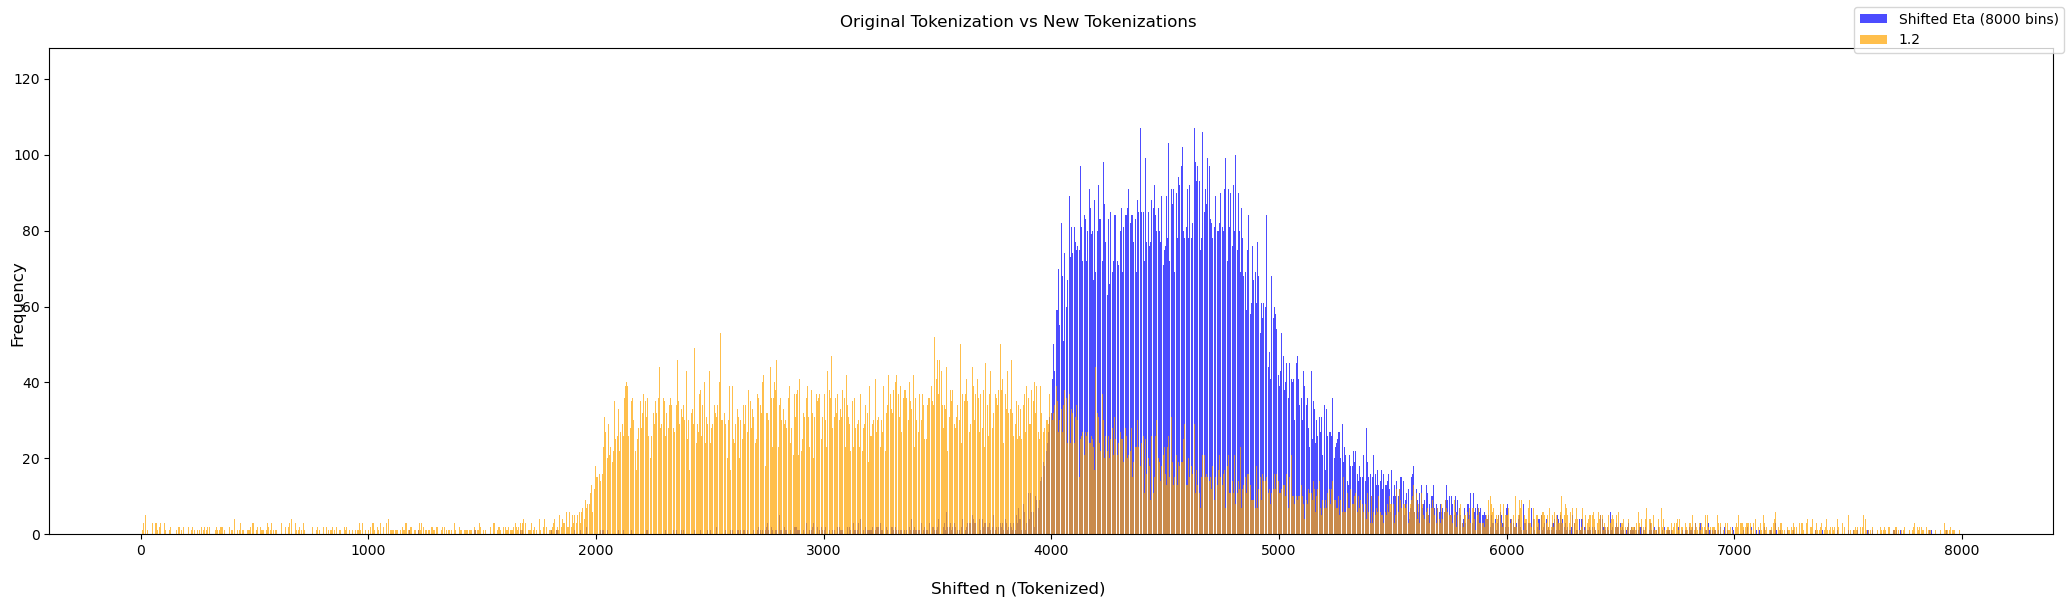

In [19]:
med_val_fig, med_val_ax = plt.subplots()
med_val_fig.suptitle("Original vs Decoded Shifted η (Median Decoded)")
med_val_fig.supxlabel("Shifted η")
med_val_fig.supylabel("Frequency")
med_val_ax.set_yscale('log')
med_val_ax.hist(shifted_eta, range=(1, 9), bins=200, label="Original", color=anal.plotting.colors[0], alpha=0.7)

mean_val_fig, mean_val_ax = plt.subplots()
mean_val_fig.suptitle("Original vs Decoded Shifted η (Mean Decoded)")
mean_val_fig.supxlabel("Shifted η")
mean_val_fig.supylabel("Frequency")
mean_val_ax.set_yscale('log')
mean_val_ax.hist(shifted_eta, range=(1, 9), bins=200, label="Original", color=anal.plotting.colors[0], alpha=0.7)

tok_fig, tok_ax = plt.subplots()
tok_fig.suptitle("Original Tokenization vs New Tokenizations")
tok_fig.supxlabel("Shifted η (Tokenized)")
tok_fig.supylabel("Frequency")
tok_ax.bar(dict(tokenized_granular_shifted_eta_freq).keys(), dict(tokenized_granular_shifted_eta_freq).values(), label=f'Shifted Eta (8000 bins)', color=anal.plotting.colors[0], alpha=0.7)

# Through testing, 1.6 doesn't provide much benefit toward reconstruction, but does compress the freq distribution.
# 1.2 is every so lightly worse at reconstruction than 1.4, but provides a more compressed frequency distribution and the
#   reconstruction difference is only noticable in log scale.
# 1.0 struggles with reconstruction, but provides a very compressed frequency distribution.
# 1.2 is the best balance between reconstruction and compression.

# Furthermore, bin mean decoding is consistently better than bin median decoding, so we will use that.
for idx, sig in enumerate([1.2]):
    n_gaussian_shifted_eta_bins = 8000
    gaussian_shifted_eta_bins = gaussian_space(1, 9, n_gaussian_shifted_eta_bins, 5.8, sigma=sig)
    gaussian_bin_tokenized_shifted_eta = np.digitize(shifted_eta, bins=gaussian_shifted_eta_bins)
    gaussian_bin_tokenized_shifted_eta_freq = Counter(gaussian_bin_tokenized_shifted_eta)
    full_tokenized_freq = {i: 0 for i in range(0, n_gaussian_shifted_eta_bins)}
    full_tokenized_freq.update(gaussian_bin_tokenized_shifted_eta_freq)
    gaussian_bin_tokenized_shifted_eta_freq = sorted(full_tokenized_freq.items(), key=lambda x: x[0])
        
    # Bin meadian
    median_decoded_eta = detokenize_gaussian_bins(gaussian_bin_tokenized_shifted_eta, gaussian_shifted_eta_bins)

    # Bin mean
    bin_means = build_bin_means(shifted_eta, gaussian_shifted_eta_bins)
    _tokens = np.digitize(shifted_eta, gaussian_shifted_eta_bins[1:-1], right=True)
    _tokens = np.clip(_tokens, 0, len(bin_means) - 1)
    mean_decoded_eta = bin_means[_tokens]
    
    med_val_ax.hist(median_decoded_eta, range=(1, 9), bins=200, label=f'{sig}', color=anal.plotting.colors[idx + 1], alpha=0.5)
    mean_val_ax.hist(mean_decoded_eta, range=(1, 9), bins=200, label=f'{sig}', color=anal.plotting.colors[idx + 1], alpha=0.5)
    tok_ax.bar(dict(gaussian_bin_tokenized_shifted_eta_freq).keys(), dict(gaussian_bin_tokenized_shifted_eta_freq).values(), label=f'{sig}', color=anal.plotting.colors[idx + 1], alpha=0.7)
    
med_val_fig.legend()
med_val_fig.tight_layout()
med_val_fig.show()
mean_val_fig.legend()
mean_val_fig.tight_layout()
mean_val_fig.show()
tok_fig.legend()
tok_fig.tight_layout()
tok_fig.show()